# <span style="color:blue">**DengAI Case Count Forecasting**</span>

<a id="introduction"></a>
# <span style="color:blue">Introduction</span>

In this notebook, we'll forecast **weekly dengue fever cases** for **San Juan, Puerto Rico** and **Iquitos, Peru** using environmental and climate variables, build baseline and advanced models, and generate a valid submission for the DrivenData competition.

<a id="project-description"></a>
### <span style="color:blue">**Project description:**</span>

This challenge asks us to **predict the `total_cases`** of dengue for each **(city, year, weekofyear)** in a held-out test set covering both **San Juan (`sj`)** and **Iquitos (`iq`)**. Inputs include weather station data (temperatures, precipitation), reanalysis fields (humidity, air temp, precipitation), and satellite vegetation indices (NDVI). The **test set is a pure future hold-out** with no overlap with training. Competition performance is evaluated by **Mean Absolute Error (MAE)**, and submissions must include **integer** case counts for **both cities in a single CSV**.  

**Competition link:** https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/


<a id="task-summary"></a>
### <span style="color:blue">**Task summary:**</span>
**Frame the problem — what we’re predicting and with what.**  
This is a **supervised regression** problem: learn a function that maps **inputs** (weather, climate, vegetation indices, etc.) to an **output** (`total_cases`). It’s also **time-series forecasting with exogenous variables** (features that are not the target), at a **weekly cadence** and for **two cities** (San Juan and Iquitos).  
- Each row ≈ one **(city, year, weekofyear)**.  
- Exogenous features include temperature, precipitation, humidity, NDVI, and reanalysis fields.  
- We predict **next week’s** `total_cases` for each city (one-step-ahead is a standard framing).  
- You can train one **global** model (add a `city` indicator) or **two separate** city models.

---

**Data handling — how to get a clean modeling table.**  
1) **Load & join** the provided files so you have features **and** labels in a single dataframe keyed by `(city, year, weekofyear)`.  
2) **Sort by time within each city** and **never shuffle** (time order matters).  
3) **Handle missing values** without peeking into the future: forward-fill within city, median-by-city, or model-based imputation fit on past only.  
4) **Feature engineering (no leakage):**  
   - **Lags:** past values as predictors (e.g., `reanalysis_air_temp_k_lag_1`, …, `_lag_26`).  
   - **Rolling stats:** moving averages / std over past windows (e.g., 4, 8, 12, 26 weeks).  
   - **Seasonality:** encode `weekofyear` with `sin/cos` to capture yearly cycles.  
   - **City interactions:** allow different effects or trees to split by `city`.

---

**Validation — get honest performance estimates (avoid leakage):**

Standard k-fold mixes past and future, which **leaks information** and inflates accuracy. We need splits that respect time.

**Recommended strategies**
- **Expanding window (rolling origin):** train on weeks `1…T`, validate on `T+1…T+h`; then slide the cut forward and repeat.  
- **Blocked (forward) CV:** partition the timeline into sequential blocks; for each fold, train on earlier blocks and validate on the immediately following block.  
- **City handling:** do splits **within each city’s timeline** (or include `city` as a feature in a single global timeline) but always preserve order.

---

**Modeling — start simple, then add power.:**

**Baselines**
- **Naive:** predict last week’s `total_cases` (per city).
- **Moving average / median:** e.g., median of the past 8 weeks.
- **Linear/regularized:** Ridge / Lasso / ElasticNet on engineered features.

**Tree ensembles**
- Random Forest, Gradient Boosting, XGBoost / LightGBM / CatBoost (handle nonlinearity and interactions).

**Count-aware options**
- Poisson or Negative Binomial regression can be a good fit for count data (often with a log-link).

**City-specific vs. global**
- **City-specific:** captures unique city dynamics; fewer data points per model.
- **Global:** shares information; add `city` as a feature; may generalize better.

---

**Post-processing — make predictions submission-ready.:**

- **Clip negatives to zero** (can’t have negative cases).
- **Round to integers** (competition typically expects integer counts).
- Build **one CSV covering both cities** with the exact ID columns and your `total_cases` predictions; keep the same ordering as the competition’s test set.

**Deliverables — what you’ll hand in.**

- A clean, reproducible notebook (set random seeds, record library versions, keep data paths tidy).
- A valid submission.csv generated from the test set.
- At the end: a short slide deck (approach/results) and a small dashboard to explore model outputs (city, date range, error plots).


<a id="links"></a>
### <span style="color:blue">**Presentation & dashboard:**</span>

- 📑 **Slide deck:** _to be added at the end_ → [Open presentation](#)
- 📊 **Dashboard:** _to be added at the end_ → [Open dashboard](#)

> Replace the `#` links above once the artifacts are created.

<a id="toc"></a>
### <span style="color:blue">**Table of contents:**</span>

- [Introduction](#introduction)
  - [Project description](#project-description)
  - [Task summary](#task-summary)
  - [Presentation & dashboard](#links)
  - [Importing libraries](#importing-libraries)

<a id="importing-libraries"></a>
### <span style="color:blue">**Importing Libraries:**</span>

In [31]:
# Minimal core imports (add more libraries as needed)
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display


# Reproducibility
SEED = 42
np.random.seed(SEED)

print("Core libraries imported. SEED:", SEED)

Core libraries imported. SEED: 42


<a id="step1"></a>
## <span style="color:blue">Step 1. Overview of the Dataset</span>


<a id="step1-0"></a>
### <span style="color:blue">**Data fields:**</span>

The competition provides four CSV files:

1. **`dengue_features_train.csv`** – Weekly features for training: city/date indicators, weather station measurements, reanalysis variables, satellite precipitation, NDVI.  
2. **`dengue_labels_train.csv`** – Training **labels**: weekly `total_cases` keyed by `(city, year, weekofyear)`.  
3. **`dengue_features_test.csv`** – Weekly **features** for the test period (future hold-out, no labels).  
4. **`submission_format.csv`** – Template for your predictions: `(city, year, weekofyear, total_cases)` with integer counts.

**Key columns:** 4 columns
- `city` (`sj`/`iq`)
- `year`, 
- `weekofyear` 
- `week_start_date`
   
**Target:** 1 column
- `total_cases` (train only)
  
**Feature columns:** 20 columns 

Weather station measurements
- `station_max_temp_c`
- `station_min_temp_c`
- `station_avg_temp_c`
- `station_precip_mm`
- `station_diur_temp_rng_c`

Reanalysis variables
- `reanalysis_air_temp_k`
- `reanalysis_avg_temp_k`
- `reanalysis_max_air_temp_k`
- `reanalysis_min_air_temp_k`
- `reanalysis_dew_point_temp_k`
- `reanalysis_relative_humidity_percent`
- `reanalysis_specific_humidity_g_per_kg`
- `reanalysis_precip_amt_kg_per_m2`
- `reanalysis_tdtr_k`
- `reanalysis_sat_precip_amt_mm`

Satellite / remote-sensing precipitation (non-reanalysis)
- `precipitation_amt_mm`

Vegetation (NDVI)
- `ndvi_ne`
- `ndvi_nw`
- `ndvi_se`
- `ndvi_sw`

<a id="step1-1"></a>
### <span style="color:blue">**Dataset paths:**</span>

- `data/raw/dengue_features_train.csv`  
- `data/raw/dengue_labels_train.csv`  
- `data/raw/dengue_features_test.csv`  
- `data/raw/submission_format.csv`

<a id="step1-2"></a>
### <span style="color:blue">**Reading CSV files:**</span>

We’ll load train/test features and labels, then merge training features with labels by `(city, year, weekofyear)`.

In [28]:
# Point directly to your data folder (Notebook is in Notebooks/, data is in data/raw/)
DATA_DIR = Path("../data/raw")  # change to Path("data/raw") if running from project root

FEATURES_TRAIN_PATH = DATA_DIR / "dengue_features_train.csv"
LABELS_TRAIN_PATH   = DATA_DIR / "dengue_labels_train.csv"
FEATURES_TEST_PATH  = DATA_DIR / "dengue_features_test.csv"
SUBMISSION_FMT_PATH = DATA_DIR / "submission_format.csv"

# Load csv's
feat_train = pd.read_csv(FEATURES_TRAIN_PATH, parse_dates=["week_start_date"])
labels    = pd.read_csv(LABELS_TRAIN_PATH)
feat_test = pd.read_csv(FEATURES_TEST_PATH,  parse_dates=["week_start_date"])
sub_fmt   = pd.read_csv(SUBMISSION_FMT_PATH)

# Merge features + labels for training EDA/modeling
key_cols = ["city", "year", "weekofyear"]
train_df = feat_train.merge(labels, on=key_cols, how="left")

print("Shapes:")
print("  feat_train:", feat_train.shape)
print("  labels    :", labels.shape)
print("  train_df  :", train_df.shape)
print("  feat_test :", feat_test.shape)
print("  sub_fmt   :", sub_fmt.shape)


Shapes:
  feat_train: (1456, 24)
  labels    : (1456, 4)
  train_df  : (1456, 25)
  feat_test : (416, 24)
  sub_fmt   : (416, 4)


<a id="dataset-info"></a>
### <span style="color:blue">**Dataset info & dtypes:**</span>

Before EDA or feature engineering, we take a quick *schema X-ray* of each table using `pandas.DataFrame.info()`. This reveals **row counts, non-null counts, inferred dtypes, and memory usage**, and we add a compact dtype summary so we know how many numeric, datetime, and categorical columns we have. Here we verify that:
- `week_start_date` parsed as **datetime64[ns]**,
- `city` is string-like (optionally castable to **category**),
- feature columns are **numeric** (floats/ints) with NaNs where expected,
- the label `total_cases` in `labels` is integer-like,
- and **column totals** match the competition schema.

If anything looks off (e.g., dates as strings or mixed dtypes), we’ll fix types **now** to avoid downstream leakage or modeling errors.

In [36]:
# Inspect structure with .info() and summarize column counts & dtypes
from IPython.display import display
import pandas as pd  # safe if this cell is run standalone

def info_and_dtype_counts(df: pd.DataFrame, name: str):
    print(f"\n{'='*22} {name} .info() {'='*22}")
    # .info() prints a nice schema overview (non-null counts, dtypes, memory)
    df.info(memory_usage="deep")
    # Summarize total columns and dtype counts in a compact table
    n_rows, n_cols = df.shape
    dtype_counts = (
        df.dtypes.astype(str).value_counts().rename_axis("dtype").to_frame("count")
    )
    summary = pd.DataFrame(
        {
            "rows": [n_rows],
            "total_columns": [n_cols],
        },
        index=[name],
    )
    print(f"\n{name} — dtype counts:")
    display(dtype_counts.T.assign(total_columns=n_cols))

def wide_dtype_summary(frames: dict):
    # Higher-level overview: columns by major dtype family
    def family_counts(df):
        return pd.Series(
            {
                "rows": len(df),
                "cols": df.shape[1],
                "int_cols": df.select_dtypes(include=["int64", "Int64", "int32", "Int32"]).shape[1],
                "float_cols": df.select_dtypes(include=["float64", "float32"]).shape[1],
                "bool_cols": df.select_dtypes(include=["bool"]).shape[1],
                "datetime_cols": df.select_dtypes(include=["datetime64[ns]"]).shape[1],
                "object_cols": df.select_dtypes(include=["object"]).shape[1],
                "category_cols": df.select_dtypes(include=["category"]).shape[1],
            }
        )

    overview = pd.DataFrame({name: family_counts(df) for name, df in frames.items()}).T
    print("\nSummary by major dtype family:")
    display(overview)

# Run the checks (assumes you've already created these DataFrames above)
frames = {
    "feat_train": feat_train,
    "labels": labels,
    "train_df": train_df,
    "feat_test": feat_test,
    "sub_fmt": sub_fmt,
}

for name, df in frames.items():
    info_and_dtype_counts(df, name)

wide_dtype_summary(frames)



====================== feat_train .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9

dtype,float64,int64,object,datetime64[ns],total_columns
count,20,2,1,1,24



====================== labels .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         1456 non-null   object
 1   year         1456 non-null   int64 
 2   weekofyear   1456 non-null   int64 
 3   total_cases  1456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 106.8 KB

labels — dtype counts:


dtype,int64,object,total_columns
count,3,1,4



====================== train_df .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9  

dtype,float64,int64,object,datetime64[ns],total_columns
count,20,3,1,1,25



====================== feat_test .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   416 non-null    object        
 1   year                                   416 non-null    int64         
 2   weekofyear                             416 non-null    int64         
 3   week_start_date                        416 non-null    datetime64[ns]
 4   ndvi_ne                                373 non-null    float64       
 5   ndvi_nw                                405 non-null    float64       
 6   ndvi_se                                415 non-null    float64       
 7   ndvi_sw                                415 non-null    float64       
 8   precipitation_amt_mm                   414 non-null    float64       
 9   

dtype,float64,int64,object,datetime64[ns],total_columns
count,20,2,1,1,24



====================== sub_fmt .info() ======================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   city         416 non-null    object
 1   year         416 non-null    int64 
 2   weekofyear   416 non-null    int64 
 3   total_cases  416 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 30.6 KB

sub_fmt — dtype counts:


dtype,int64,object,total_columns
count,3,1,4



Summary by major dtype family:


,rows,cols,int_cols,float_cols,bool_cols,datetime_cols,object_cols,category_cols
feat_train,1456,24,2,20,0,1,1,0
labels,1456,4,3,0,0,0,1,0
train_df,1456,25,3,20,0,1,1,0
feat_test,416,24,2,20,0,1,1,0
sub_fmt,416,4,3,0,0,0,1,0


<a id="step1-3"></a>
### <span style="color:blue">**Identifying null values:**</span>

Quick scan of missing values (count and % of rows) in train/test features.


In [32]:
# Missing values for EVERY column, plus per-city breakdown (counts and %)
from IPython.display import display
import pandas as pd  # safe if run standalone

def null_report_all_by_city(
    df: pd.DataFrame,
    name: str,
    city_col: str = "city",
    sort_by: str = "nulls",
    ascending: bool = False,
    show_zeros: bool = True,
):
    """
    Show missing values per column (overall), and add two more columns per city:
    - nulls_<city>: count of NaNs within that city
    - percent_<city>: percent of NaNs within that city
    """
    if city_col not in df.columns:
        raise ValueError(f"Column '{city_col}' not found in dataframe.")

    n_total = len(df)
    total_nulls = df.isna().sum()
    total_percent = (total_nulls / n_total) * 100

    # Determine city order (prefer sj, iq if present)
    cities = list(df[city_col].dropna().unique())
    preferred = ["sj", "iq"]
    ordered = [c for c in preferred if c in cities] + [c for c in sorted(cities) if c not in preferred]

    # Build output table
    out = pd.DataFrame({
        "nulls": total_nulls,
        "percent": total_percent
    })

    # Add per-city columns
    for c in ordered:
        sub = df[df[city_col] == c]
        n_city = len(sub)
        if n_city == 0:  # safety
            out[f"nulls_{c}"] = 0
            out[f"percent_{c}"] = 0.0
        else:
            city_nulls = sub.isna().sum()
            out[f"nulls_{c}"] = city_nulls
            out[f"percent_{c}"] = (city_nulls / n_city) * 100

    # Optionally drop rows with zero nulls overall
    if not show_zeros:
        out = out[out["nulls"] > 0]

    # Sort rows
    out = out.sort_values(by=sort_by, ascending=ascending)

    # Nicely format percentage columns
    for col in out.columns:
        if col.startswith("percent"):
            out[col] = out[col].round(2).astype(str) + "%"

    print(f"[{name}] Missing values per column (overall and by '{city_col}'):")
    display(out)

# Usage:
null_report_all_by_city(feat_train, "feat_train")
null_report_all_by_city(feat_test,  "feat_test")
# Optionally:
# null_report_all_by_city(train_df, "train_df")


[feat_train] Missing values per column (overall and by 'city'):


,nulls,percent,nulls_sj,percent_sj,nulls_iq,percent_iq
ndvi_ne,194,13.32%,191,20.41%,3,0.58%
ndvi_nw,52,3.57%,49,5.24%,3,0.58%
station_avg_temp_c,43,2.95%,6,0.64%,37,7.12%
station_diur_temp_rng_c,43,2.95%,6,0.64%,37,7.12%
ndvi_sw,22,1.51%,19,2.03%,3,0.58%
station_precip_mm,22,1.51%,6,0.64%,16,3.08%
ndvi_se,22,1.51%,19,2.03%,3,0.58%
station_max_temp_c,20,1.37%,6,0.64%,14,2.69%
station_min_temp_c,14,0.96%,6,0.64%,8,1.54%
precipitation_amt_mm,13,0.89%,9,0.96%,4,0.77%


[feat_test] Missing values per column (overall and by 'city'):


,nulls,percent,nulls_sj,percent_sj,nulls_iq,percent_iq
ndvi_ne,43,10.34%,43,16.54%,0,0.0%
station_diur_temp_rng_c,12,2.88%,2,0.77%,10,6.41%
station_avg_temp_c,12,2.88%,2,0.77%,10,6.41%
ndvi_nw,11,2.64%,11,4.23%,0,0.0%
station_min_temp_c,9,2.16%,2,0.77%,7,4.49%
station_precip_mm,5,1.2%,2,0.77%,3,1.92%
station_max_temp_c,3,0.72%,2,0.77%,1,0.64%
precipitation_amt_mm,2,0.48%,2,0.77%,0,0.0%
reanalysis_relative_humidity_percent,2,0.48%,2,0.77%,0,0.0%
reanalysis_precip_amt_kg_per_m2,2,0.48%,2,0.77%,0,0.0%


### <span style="color:blue">**Missing weeks (why and what to do):**</span>

**Purpose.** Before engineering lags/rolling features, we must confirm the data follow a *continuous weekly cadence* within each city. Any missing week would turn a “1-week lag” into a 2-week (or more) lag and could distort validation.

**What we check (gap-wise, coverage-aware).**
- Sort each city’s rows by `week_start_date`.
- For every consecutive pair of dates, compute the gap in **days**.
- Interpret gaps of **7 days** (and small drifts like **8–9 days**) as *one week advance*.  
- If the advance is more than one week, infer the **missing week start(s)** at 7-day steps between the two dates.
- Summarize per city (and optionally per city–year):
  - `observed_weeks`: number of rows actually present
  - `expected_weeks`: `observed_weeks + missing_weeks`
  - `missing_weeks`: count of inferred missing starts (internal gaps only)
  - `num_long_gaps(>7d)`: how many times we saw >7-day jumps
  - `max_gap_days`: largest day gap observed
  - A **details table** listing *all* inferred missing `week_start_date` values

**Why use `week_start_date` (not just `year + weekofyear`).**
- `weekofyear` resets each January and can disagree with the **ISO week-year** near New Year; you can see sequences like `… 51, 53, 1 …` with no `52` *even when no week is missing*.  
- The calendar **date** is the ground truth for elapsed time; it cleanly handles partial coverage years (e.g., Iquitos 2010 stops mid-year) and drifting weekdays.

**How to interpret results.**
- If `missing_weeks = 0`: your data are **internally continuous** (no holes within the observed window). It’s safe to build lags/rolls using grouped `.shift()` by city.
- Non-zero `num_long_gaps(>7d)` with `missing_weeks = 0` typically indicates **8–9 day drifts** (weekday shifts), *not* true gaps.
- If `missing_weeks > 0`: treat those as internal holes. You may (optionally) expand to a regular weekly grid for feature engineering, then drop synthetic rows before modeling/submission.

In [34]:
from IPython.display import display
import pandas as pd

def missing_week_report(df: pd.DataFrame, name: str,
                        date_col: str = "week_start_date",
                        city_col: str = "city"):
    """
    Summarize missing epidemiological weeks per city and list ALL missing week_start_date values.

    Gap-wise method:
      - Sort dates within each city.
      - gap_days = (cur - prev).days
      - weeks_advanced = max(1, round(gap_days / 7.0))   # treats 8–9 day drift as 1 week
      - missing_between = max(weeks_advanced - 1, 0)
      - Missing dates = prev + 7*k days for k=1..missing_between
    """
    if date_col not in df.columns or city_col not in df.columns:
        raise ValueError(f"Expected columns '{date_col}' and '{city_col}' not found.")

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    summary_rows, missing_rows = [], []

    for city, g in df.groupby(city_col, dropna=False):
        dates = (
            g[date_col]
            .dropna()
            .drop_duplicates()
            .sort_values()
        )

        if dates.empty:
            summary_rows.append({
                "dataset": name, "city": city,
                "start": None, "end": None,
                "observed_weeks": 0, "expected_weeks": 0, "missing_weeks": 0,
                "num_long_gaps(>7d)": 0, "max_gap_days": 0
            })
            continue

        start, end = dates.iloc[0], dates.iloc[-1]
        total_missing = 0
        num_long_gaps = 0
        max_gap_days = 0

        prev = dates.iloc[0]
        for cur in dates.iloc[1:]:
            gap_days = int((cur - prev).days)
            max_gap_days = max(max_gap_days, gap_days)
            if gap_days > 7:
                num_long_gaps += 1

            weeks_advanced = max(1, int(round(gap_days / 7.0)))
            missing_between = max(weeks_advanced - 1, 0)

            for k in range(1, missing_between + 1):
                md = (prev + pd.Timedelta(days=7 * k))
                missing_rows.append({
                    "dataset": name,
                    "city": city,
                    "missing_week_start_date": md.date(),
                    "weekday": md.day_name()
                })

            total_missing += missing_between
            prev = cur

        observed_weeks = int(dates.size)
        expected_weeks = observed_weeks + total_missing

        summary_rows.append({
            "dataset": name,
            "city": city,
            "start": start.date(),
            "end": end.date(),
            "observed_weeks": observed_weeks,
            "expected_weeks": expected_weeks,
            "missing_weeks": total_missing,
            "num_long_gaps(>7d)": num_long_gaps,
            "max_gap_days": max_gap_days
        })

    summary = pd.DataFrame(summary_rows).sort_values(["dataset", "city"]).reset_index(drop=True)

    if len(missing_rows) > 0:
        details = (pd.DataFrame(missing_rows)
                     .sort_values(["dataset", "city", "missing_week_start_date"])
                     .reset_index(drop=True))
    else:
        details = pd.DataFrame(columns=["dataset","city","missing_week_start_date","weekday"])

    print("Missing-week summary (gap-wise):")
    display(summary)

    if len(details):
        print("All missing week_start_date values (gap-wise inference):")
        display(details)
    else:
        print("No missing weeks detected.")

    return summary, details

# Usage:
_ = missing_week_report(feat_train, "feat_train")
_ = missing_week_report(feat_test,  "feat_test")


Missing-week summary (gap-wise):


,dataset,city,start,end,observed_weeks,expected_weeks,missing_weeks,num_long_gaps(>7d),max_gap_days
0,feat_train,iq,2000-07-01,2010-06-25,520,520,0,10,9
1,feat_train,sj,1990-04-30,2008-04-22,936,936,0,18,9


No missing weeks detected.
Missing-week summary (gap-wise):


,dataset,city,start,end,observed_weeks,expected_weeks,missing_weeks,num_long_gaps(>7d),max_gap_days
0,feat_test,iq,2010-07-02,2013-06-25,156,156,0,3,9
1,feat_test,sj,2008-04-29,2013-04-23,260,260,0,5,9


No missing weeks detected.


**Takeaway.** We trust the **`week_start_date` gap-wise** calculation because it respects real time, handles coverage windows, and avoids false alarms from week-numbering quirks. In our data, this method reports **no internal missing weeks**, so we can proceed with time-aware feature engineering confidently.

<a id="step1-4"></a>
### <span style="color:blue">**Displaying sample rows:**</span>

Peek at a few entries to confirm schema and value ranges.

In [21]:
print("Training features (head):")
display(feat_train.head(3))

print("Training labels (head):")
display(labels.head(3))

print("Merged training set (head):")
display(train_df.head(3))

print("Test features (head):")
display(feat_test.head(3))

print("Submission format (head):")
display(sub_fmt.head(3))


Training features (head):


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4


Training labels (head):


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4


Merged training set (head):


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.12260,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.16990,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.03225,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4


Test features (head):


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.0189,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.0124,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0


Submission format (head):


,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0


<a id="step1-5"></a>
### <span style="color:blue">**Checking for duplicates:**</span>

Ensure keys uniquely identify rows and that `(city, year, weekofyear)` combos don’t repeat.


In [22]:
def check_key_uniqueness(df, key, name):
    dups = df.duplicated(subset=key).sum()
    print(f"[{name}] duplicate key rows:", dups)

check_key_uniqueness(feat_train, key_cols, "feat_train")
check_key_uniqueness(labels,    key_cols, "labels")
check_key_uniqueness(train_df,  key_cols, "train_df")
check_key_uniqueness(feat_test, key_cols, "feat_test")


[feat_train] duplicate key rows: 0
[labels] duplicate key rows: 0
[train_df] duplicate key rows: 0
[feat_test] duplicate key rows: 0


<a id="step1-7"></a>
### <span style="color:blue">**Summary stats (`.describe`) & range checks:**</span>

We’ll compute descriptive statistics for **numeric columns** in train/test (plus the target in `train_df`) to spot anomalies (e.g., unexpected negatives, extreme values). We also add a compact **range scan** (min, 1%/99% quantiles, max, counts of negatives/zeros/NAs) to quickly flag suspicious ranges we may want to investigate.


In [37]:
# Descriptive statistics and simple range checks for anomalies

def numeric_describe(df: pd.DataFrame, name: str, percentiles=None):
    """Describe numeric columns with extra percentiles for tail checks."""
    if percentiles is None:
        percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print(f"[{name}] No numeric columns to describe.")
        return
    desc = df[num_cols].describe(percentiles=percentiles).T
    print(f"\n{name} — numeric describe (with tails):")
    display(desc)

def range_scan(df: pd.DataFrame, name: str):
    """Quick range sanity check: min/max, tails, negatives/zeros/NAs."""
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print(f"[{name}] No numeric columns for range scan.")
        return
    n = len(df)
    q01 = df[num_cols].quantile(0.01)
    q99 = df[num_cols].quantile(0.99)
    out = pd.DataFrame({
        "min": df[num_cols].min(),
        "p01": q01,
        "p99": q99,
        "max": df[num_cols].max(),
        "n_negative": (df[num_cols] < 0).sum(),
        "n_zero": (df[num_cols] == 0).sum(),
        "n_na": df[num_cols].isna().sum(),
        "rows": n
    })
    print(f"\n{name} — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):")
    display(out.sort_values(["n_negative","n_zero","n_na","min","max"], ascending=[False, False, False, True, False]))

# ---- Run on features (train/test) ----
numeric_describe(feat_train, "feat_train")
range_scan(feat_train, "feat_train")

numeric_describe(feat_test, "feat_test")
range_scan(feat_test, "feat_test")

# ---- Target summary (training labels merged) ----
if "total_cases" in train_df.columns:
    print("\ntrain_df — target `total_cases` describe:")
    display(train_df[["total_cases"]].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T)
    # Simple target sanity counts
    tc = train_df["total_cases"]
    print(
        "total_cases — negatives:", int((tc < 0).sum()),
        "| zeros:", int((tc == 0).sum()),
        "| NAs:", int(tc.isna().sum())
    )
else:
    print("`total_cases` not found in train_df (did you merge labels?).")



feat_train — numeric describe (with tails):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
year,1456.0,2001.031593,5.408314,1990.000000,1990.000000,1991.000000,1997.000000,2002.000000,2005.000000,2009.000000,2010.000000,2010.000000
weekofyear,1456.0,26.503434,15.019437,1.000000,1.000000,3.000000,13.750000,26.500000,39.250000,50.000000,52.000000,53.000000
ndvi_ne,1262.0,0.142294,0.140531,-0.406250,-0.196482,-0.074240,0.044950,0.128817,0.248483,0.363566,0.436901,0.508357
ndvi_nw,1404.0,0.130553,0.119999,-0.456100,-0.128837,-0.054293,0.049217,0.121429,0.216600,0.330700,0.388529,0.454429
ndvi_se,1434.0,0.203783,0.073860,-0.015533,0.061046,0.094823,0.155087,0.196050,0.248846,0.341862,0.406097,0.538314
ndvi_sw,1434.0,0.202305,0.083903,-0.063457,0.050746,0.088909,0.144209,0.189450,0.246982,0.368839,0.438607,0.546017
precipitation_amt_mm,1443.0,45.760388,43.715537,0.000000,0.000000,0.000000,9.800000,38.340000,70.235000,121.631000,180.960600,390.600000
reanalysis_air_temp_k,1446.0,298.701852,1.362420,294.635714,295.674143,296.531429,297.658929,298.646429,299.833571,300.850000,301.248000,302.200000
reanalysis_avg_temp_k,1446.0,299.225578,1.261715,294.892857,296.360357,297.192857,298.257143,299.289286,300.207143,301.119643,301.616429,302.928571
reanalysis_dew_point_temp_k,1446.0,295.246356,1.527810,289.642857,290.982857,292.474643,294.118929,295.640714,296.460000,297.123929,297.562786,298.450000



feat_train — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):


,min,p01,p99,max,n_negative,n_zero,n_na,rows
ndvi_nw,-0.456100,-0.128837,0.388529,0.454429,173,0,52,1456
ndvi_ne,-0.406250,-0.196482,0.436901,0.508357,171,0,194,1456
ndvi_sw,-0.063457,0.050746,0.438607,0.546017,2,0,22,1456
ndvi_se,-0.015533,0.061046,0.406097,0.538314,1,0,22,1456
precipitation_amt_mm,0.000000,0.000000,180.960600,390.600000,0,239,13,1456
reanalysis_sat_precip_amt_mm,0.000000,0.000000,180.960600,390.600000,0,239,13,1456
station_precip_mm,0.000000,0.000000,234.540000,543.300000,0,42,22,1456
reanalysis_precip_amt_kg_per_m2,0.000000,0.600000,204.535000,570.500000,0,3,10,1456
station_diur_temp_rng_c,4.528571,4.830286,13.292000,15.800000,0,0,43,1456
station_avg_temp_c,21.400000,24.173143,29.412571,30.800000,0,0,43,1456



feat_test — numeric describe (with tails):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
year,416.0,2010.766827,1.434835,2008.000000,2008.000000,2008.000000,2010.000000,2011.000000,2012.000000,2013.000000,2013.000000,2013.000000
weekofyear,416.0,26.439904,14.978257,1.000000,1.000000,3.000000,13.750000,26.000000,39.000000,50.000000,52.000000,53.000000
ndvi_ne,373.0,0.126050,0.164353,-0.463400,-0.232060,-0.113360,-0.001500,0.110100,0.263329,0.373509,0.441414,0.500400
ndvi_nw,405.0,0.126803,0.141420,-0.211800,-0.132218,-0.065067,0.015975,0.088700,0.242400,0.370066,0.429114,0.649000
ndvi_se,415.0,0.207702,0.079102,0.006200,0.052241,0.087765,0.148670,0.204171,0.254871,0.344894,0.407302,0.453043
ndvi_sw,415.0,0.201721,0.092028,-0.014671,0.056201,0.077759,0.134079,0.186471,0.253243,0.382305,0.438449,0.529043
precipitation_amt_mm,414.0,38.354324,35.171126,0.000000,0.000000,0.000000,8.175000,31.455000,57.772500,104.624000,143.923300,169.340000
reanalysis_air_temp_k,414.0,298.818295,1.469501,294.554286,295.719986,296.551429,297.751429,298.547143,300.240357,300.949071,301.330114,301.935714
reanalysis_avg_temp_k,414.0,299.353071,1.306233,295.235714,296.495286,297.197500,298.323214,299.328571,300.521429,301.200000,301.660929,303.328571
reanalysis_dew_point_temp_k,414.0,295.419179,1.523099,290.818571,291.441686,292.728643,294.335714,295.825000,296.643571,297.336214,297.654000,297.794286



feat_test — range scan (min/p01/p99/max, counts of negatives/zeros/NAs):


,min,p01,p99,max,n_negative,n_zero,n_na,rows
ndvi_ne,-0.463400,-0.232060,0.441414,0.500400,95,0,43,416
ndvi_nw,-0.211800,-0.132218,0.429114,0.649000,71,0,11,416
ndvi_sw,-0.014671,0.056201,0.438449,0.529043,1,0,1,416
precipitation_amt_mm,0.000000,0.000000,143.923300,169.340000,0,57,2,416
reanalysis_sat_precip_amt_mm,0.000000,0.000000,143.923300,169.340000,0,57,2,416
station_precip_mm,0.000000,0.000000,152.780000,212.000000,0,12,5,416
reanalysis_precip_amt_kg_per_m2,0.000000,0.313000,244.905000,301.400000,0,1,2,416
station_diur_temp_rng_c,4.042857,4.842857,13.497000,14.725000,0,0,12,416
station_avg_temp_c,24.157143,24.840514,29.726857,30.271429,0,0,12,416
station_min_temp_c,14.200000,17.800000,26.100000,26.700000,0,0,9,416



train_df — target `total_cases` describe:


,count,mean,std,min,1%,5%,50%,95%,99%,max
total_cases,1456.0,24.675137,43.596,0.0,0.0,0.0,12.0,81.25,236.75,461.0


total_cases — negatives: 0 | zeros: 100 | NAs: 0


**Summary of `.describe()` & range-scan findings:**

**Overall shape**
- **Training features (`feat_train`)**: 1,456 rows (1990–2010).  
- **Test features (`feat_test`)**: 416 rows (2008–2013).  
- Columns and units look consistent between train and test.

**Temperature-related variables**
- **Reanalysis temps (K)** center around **295–303 K** (~22–30 °C).  
- **Station temps (°C)**: `station_min_temp_c` **14.7–25.6**, `station_max_temp_c` **26.7–42.2**, `station_avg_temp_c` **21.4–30.8**.  
- **Diurnal range** (`station_diur_temp_rng_c`) mostly **4.5–15.8** → plausible tropics.

**Moisture / precipitation**
- **Relative humidity** spans **~58–99%** (train) and **~65–98%** (test) — reasonable.  
- **Specific humidity** ~**11.7–20.5 g/kg** — reasonable tropical range.  
- **Precipitation** variables have **many zeros** (dry weeks) and **heavy right tails** (weekly totals up to ~**390–570** in mm/kg·m⁻²); extremes look plausible for tropical rainfall but are **highly skewed** → consider **`log1p` transforms** or robust models.

**Vegetation (NDVI)**
- NDVI in **[~−0.46, ~0.54]** with some negatives — expected (NDVI ranges −1..1).  
- NDVI has the **most missingness** in train (e.g., `ndvi_ne` ~**194 NAs** of 1,456). Plan time-aware imputation (e.g., city-level seasonal interpolation).

**Missing values**
- Aside from NDVI, several features show **small NA counts** (e.g., precipitation, a few station variables). Nothing suggests corrupt columns.  
- **Zeros** occur primarily in precipitation metrics (real zeros, not missing).

**Target (`total_cases`)**
- 1,456 values, **no NAs or negatives**; **100 zeros** (quiet weeks).  
- Highly **right-skewed**: median **12**, 95th **≈81**, 99th **≈237**, **max 461** → anticipate **count-like** behavior and possible benefit from **Poisson/NegBin** or **log-target** modeling (with care when back-transforming and rounding).

**Sanity checks**
- `year` and `weekofyear` cover expected ranges (1–53) with no obvious anomalies.  
- Using the **gap-wise `week_start_date`** method, we found **no internal missing weeks** within each city’s observed window → safe to engineer **lags/rolling features**.

**Actionable next steps**
- **Impute**: time-aware (by city) for NDVI and small NA pockets; avoid leakage (fit imputers on past data only).  
- **Transform**: consider `log1p`/winsorization for precipitation & possibly `total_cases` (for linear models).  
- **Standardize**: optionally scale continuous features (model-dependent).  
- **Validate**: use time-aware CV with MAE; monitor per-city error due to differing scales.

**Overall shape**
- **Training features (`feat_train`)**: 1,456 rows (1990–2010).  
- **Test features (`feat_test`)**: 416 rows (2008–2013).  
- Columns and units look consistent between train and test.

**Temperature-related variables**
- **Reanalysis temps (K)** center around **295–303 K** (~22–30 °C).  
- **Station temps (°C)**: `station_min_temp_c` **14.7–25.6**, `station_max_temp_c` **26.7–42.2**, `station_avg_temp_c` **21.4–30.8**.  
- **Diurnal range** (`station_diur_temp_rng_c`) mostly **4.5–15.8** → plausible tropics.

**Moisture / precipitation**
- **Relative humidity** spans **~58–99%** (train) and **~65–98%** (test) — reasonable.  
- **Specific humidity** ~**11.7–20.5 g/kg** — reasonable tropical range.  
- **Precipitation** variables have **many zeros** (dry weeks) and **heavy right tails** (weekly totals up to ~**390–570** in mm/kg·m⁻²); extremes look plausible for tropical rainfall but are **highly skewed** → consider **`log1p` transforms** or robust models.

**Vegetation (NDVI)**
- NDVI in **[~−0.46, ~0.54]** with some negatives — expected (NDVI ranges −1..1).  
- NDVI has the **most missingness** in train (e.g., `ndvi_ne` ~**194 NAs** of 1,456). Plan time-aware imputation (e.g., city-level seasonal interpolation).

**Missing values**
- Aside from NDVI, several features show **small NA counts** (e.g., precipitation, a few station variables). Nothing suggests corrupt columns.  
- **Zeros** occur primarily in precipitation metrics (real zeros, not missing).

**Target (`total_cases`)**
- 1,456 values, **no NAs or negatives**; **100 zeros** (quiet weeks).  
- Highly **right-skewed**: median **12**, 95th **≈81**, 99th **≈237**, **max 461** → anticipate **count-like** behavior and possible benefit from **Poisson/NegBin** or **log-target** modeling (with care when back-transforming and rounding).

**Sanity checks**
- `year` and `weekofyear` cover expected ranges (1–53) with no obvious anomalies.  
- Using the **gap-wise `week_start_date`** method, we found **no internal missing weeks** within each city’s observed window → safe to engineer **lags/rolling features**.

**Actionable next steps**
- **Impute**: time-aware (by city) for NDVI and small NA pockets; avoid leakage (fit imputers on past data only).  
- **Transform**: consider `log1p`/winsorization for precipitation & possibly `total_cases` (for linear models).  
- **Standardize**: optionally scale continuous features (model-dependent).  
- **Validate**: use time-aware CV with MAE; monitor per-city error due to differing scales.


<a id="step1-6"></a>
### <span style="color:blue">**Concluding remarks:**</span>

- Merged **training table** (`train_df`) keyed by `(city, year, weekofyear)` with `total_cases` as the target.  
- **Future hold-out** **test** table (`feat_test`) with the same feature schema (no labels).  
- Some features have **missing values** (`NaN`) by design—will require time-aware imputation.
- **Missing weeks:** Using the **`week_start_date` gap-wise, coverage-aware** check, we found **no internal missing weeks** for either city within the observed coverage window; the weekly cadence is continuous.
- No duplicate key rows are expected.
- Optionally transform skewed variables (e.g., **precipitation**) and standardize as needed. 

Next: explore distributions, correlation, and seasonality for features and target variables.


<a id="eda"></a>
# <span style="color:blue">Step 2. Exploratory Data Analysis (EDA)</span>


<a id="eda-features"></a>
### <span style="color:blue">**Feature analysis — distributions (histograms & boxplots):**</span>

We first examine the **marginal distributions** of the features to spot skew, outliers, and city differences.


For every numeric feature, we’ll draw **two panels**: **San Juan (left)** and **Iquitos (right)**. Each panel stacks a **boxplot on top** of a **histogram** sharing the same x-axis, so we see the distribution shape and the five-number summary together.

Total numeric features: 20


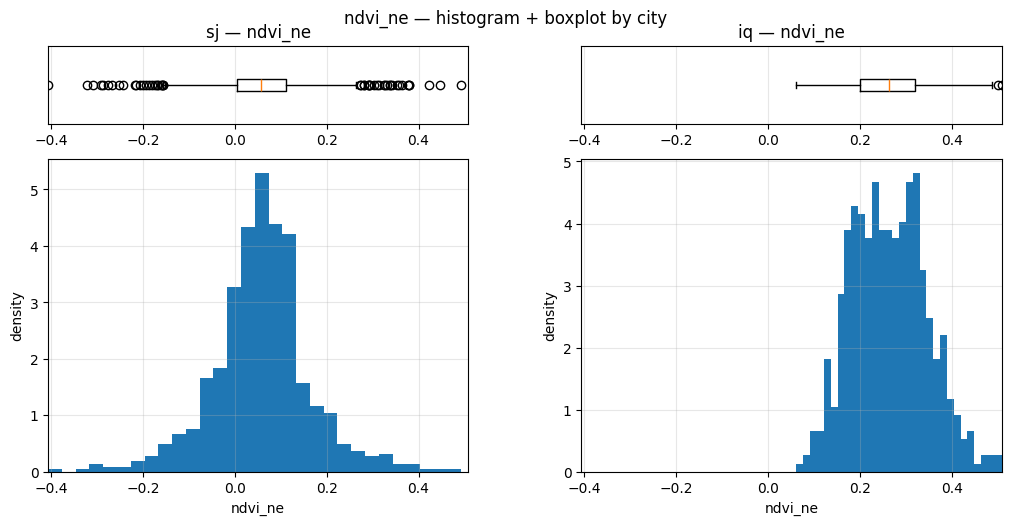

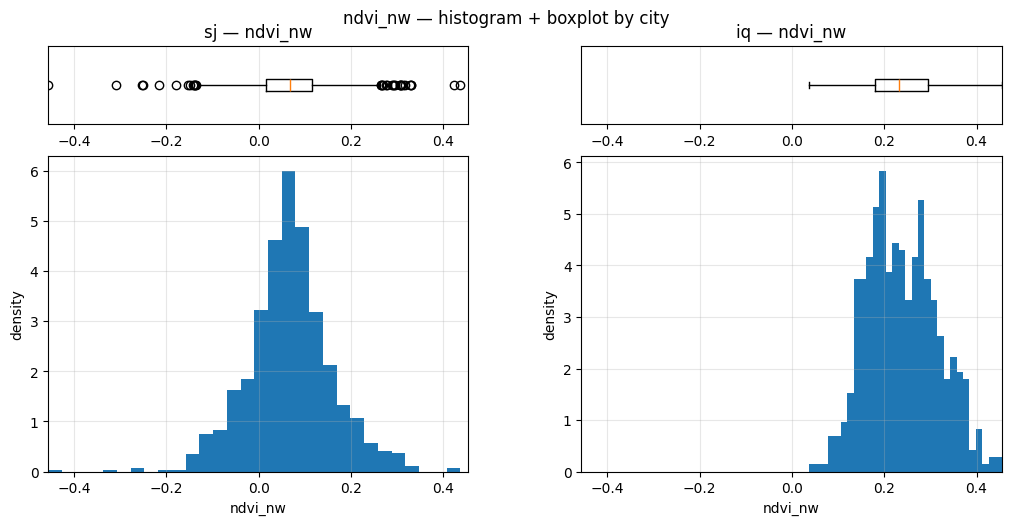

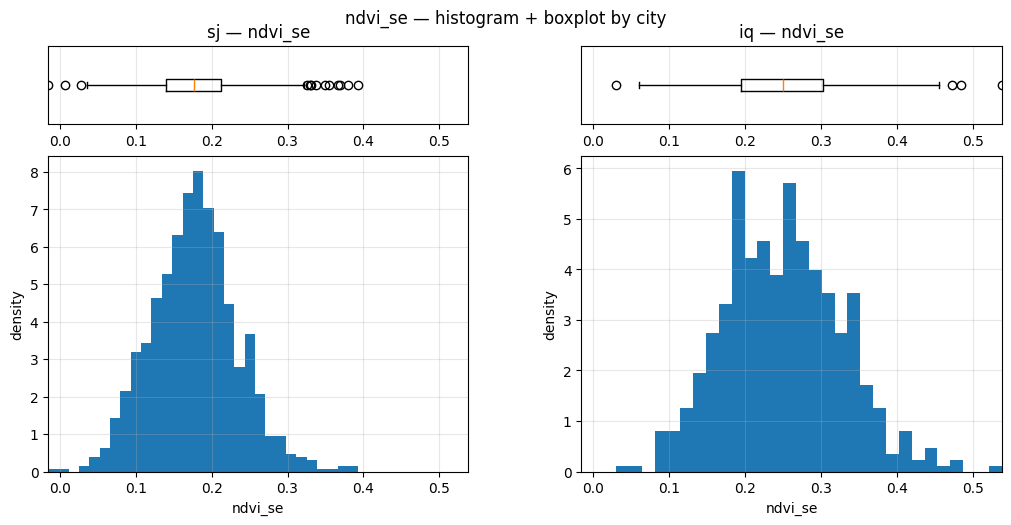

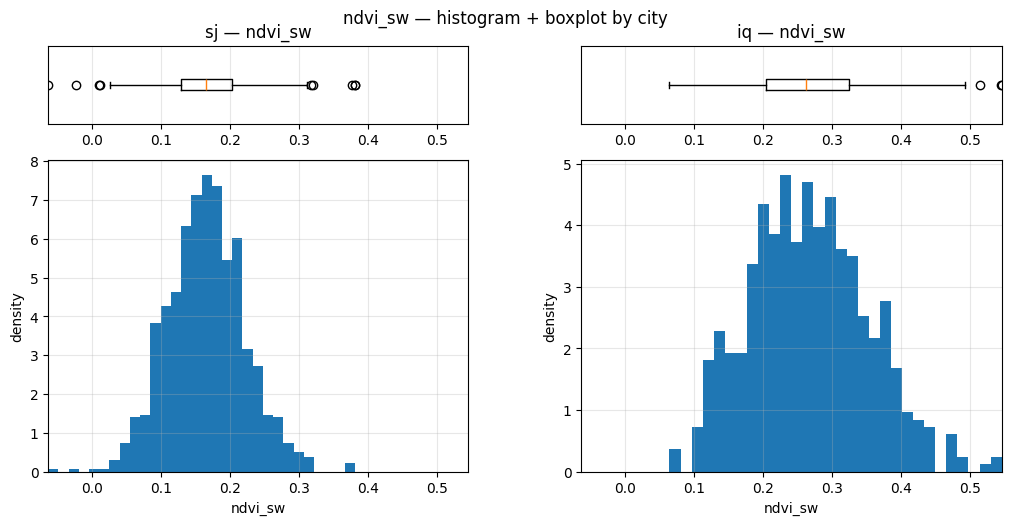

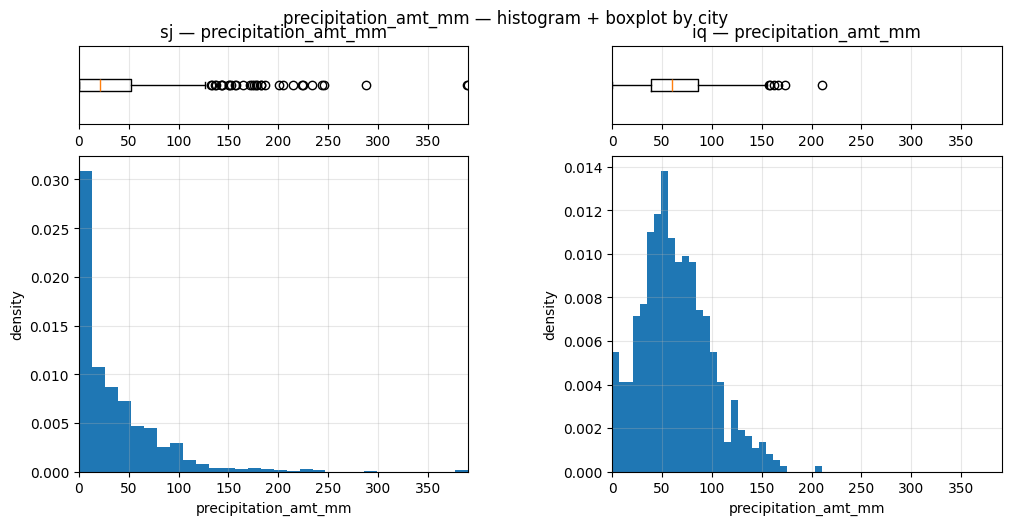

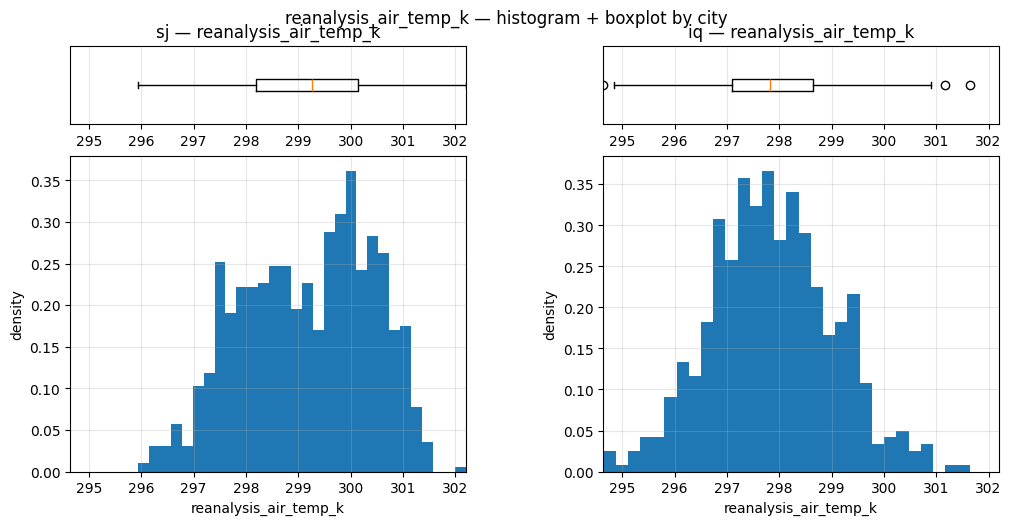

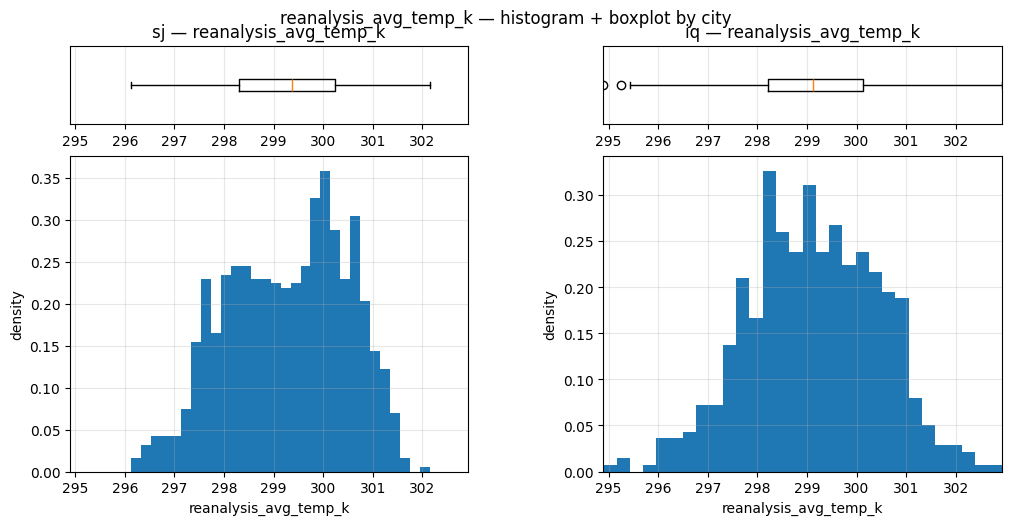

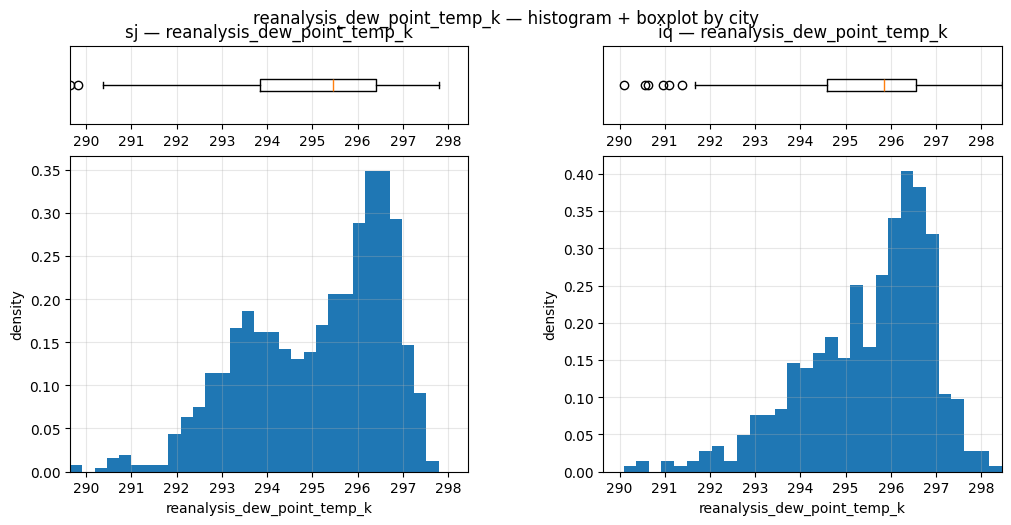

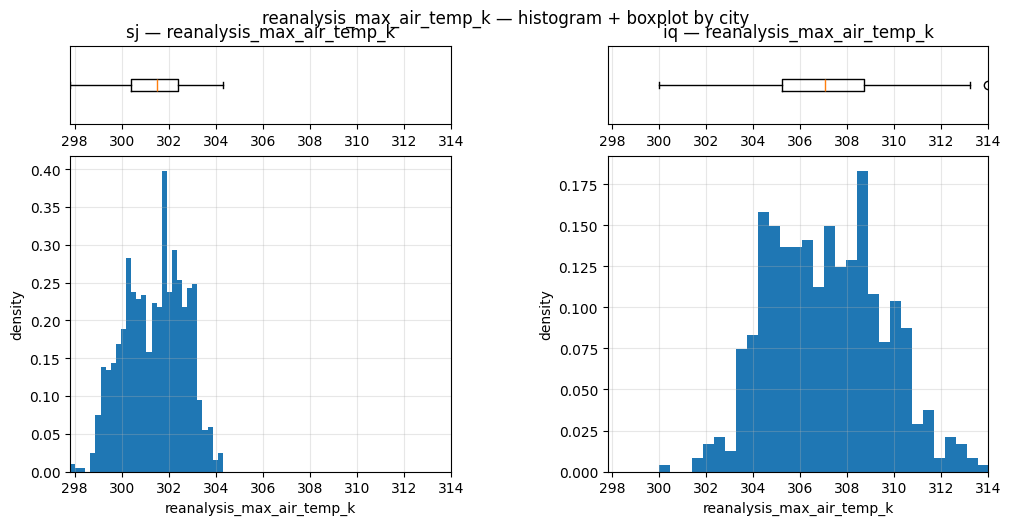

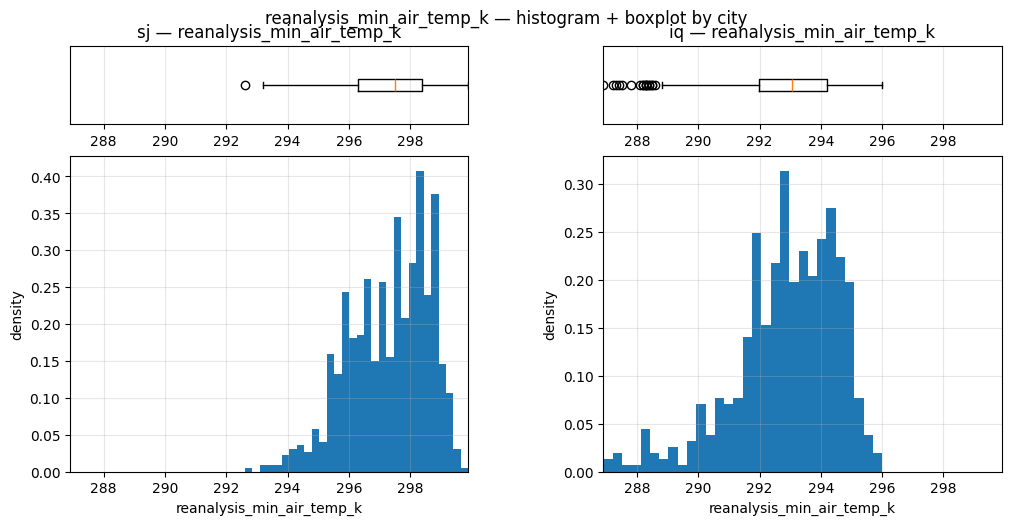

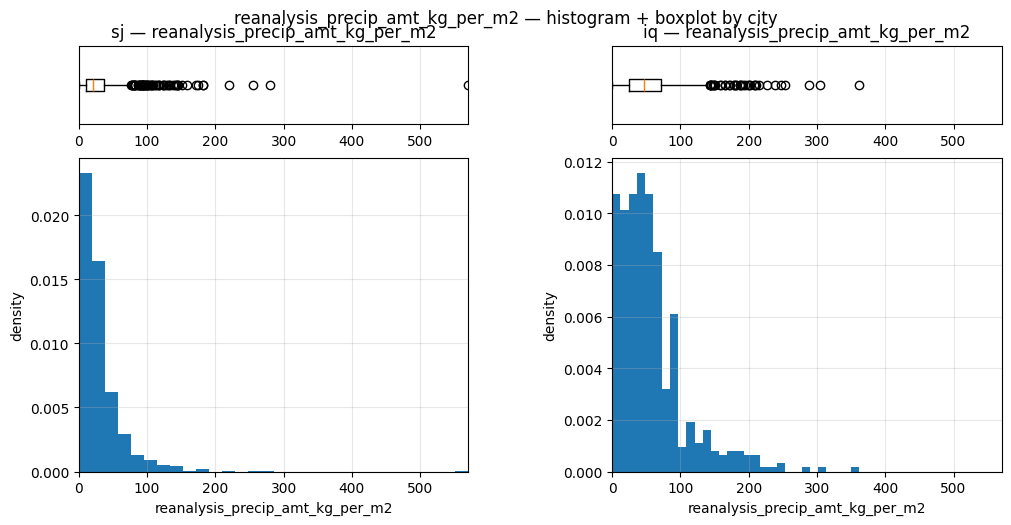

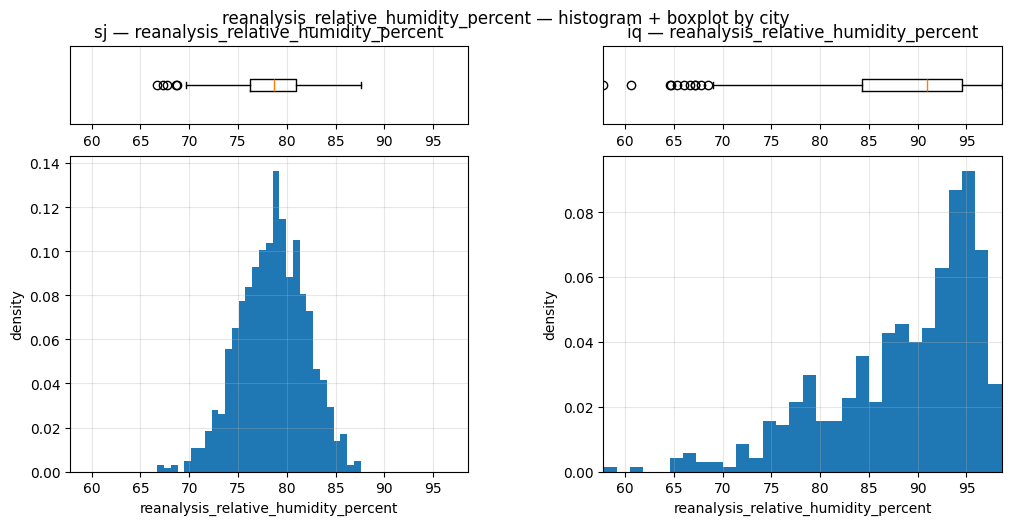

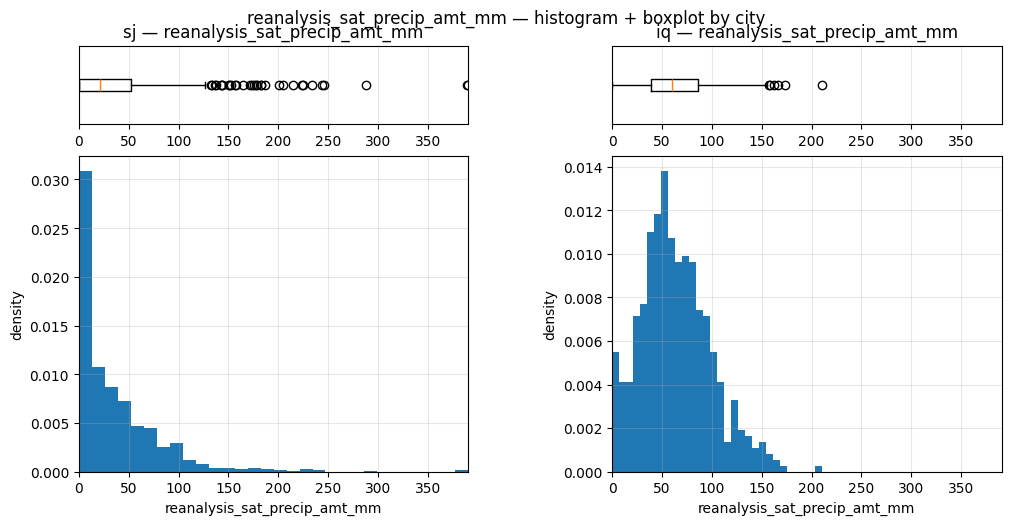

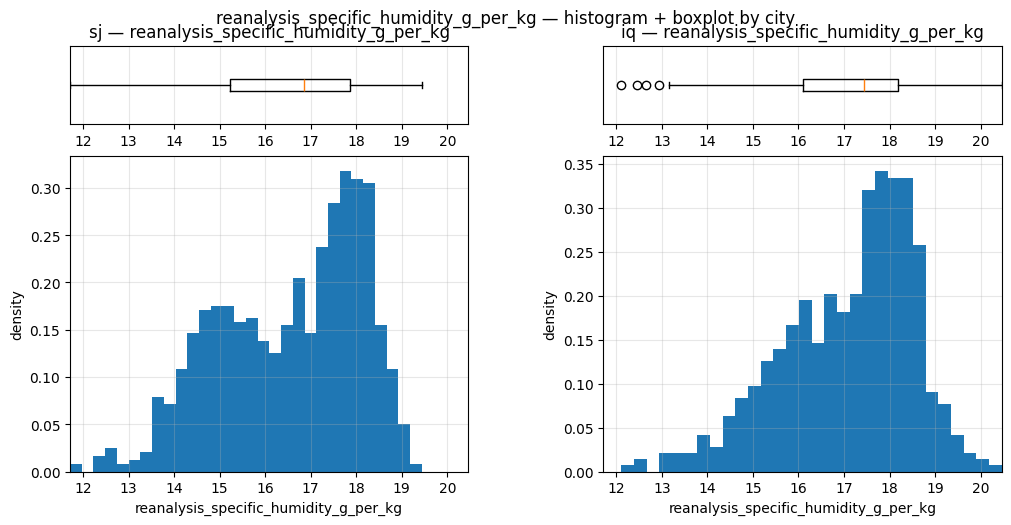

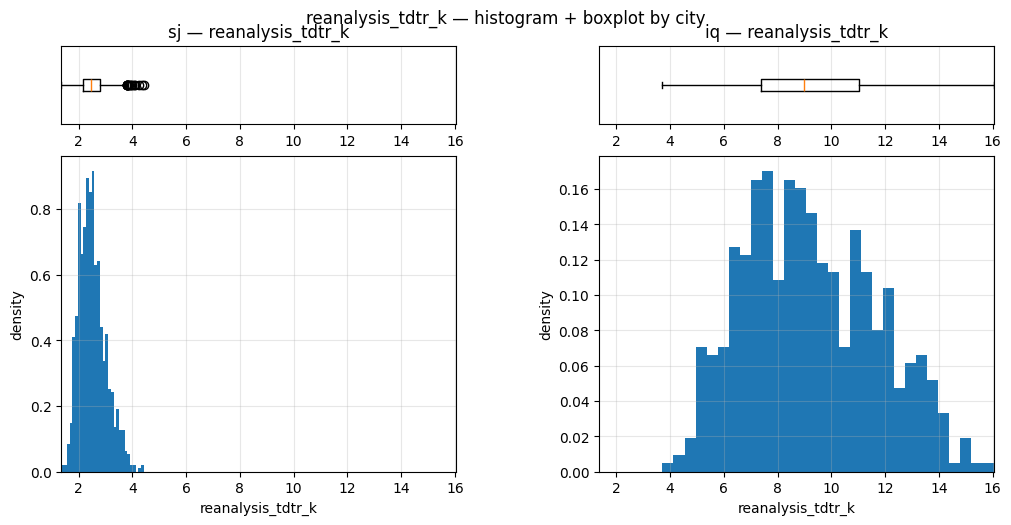

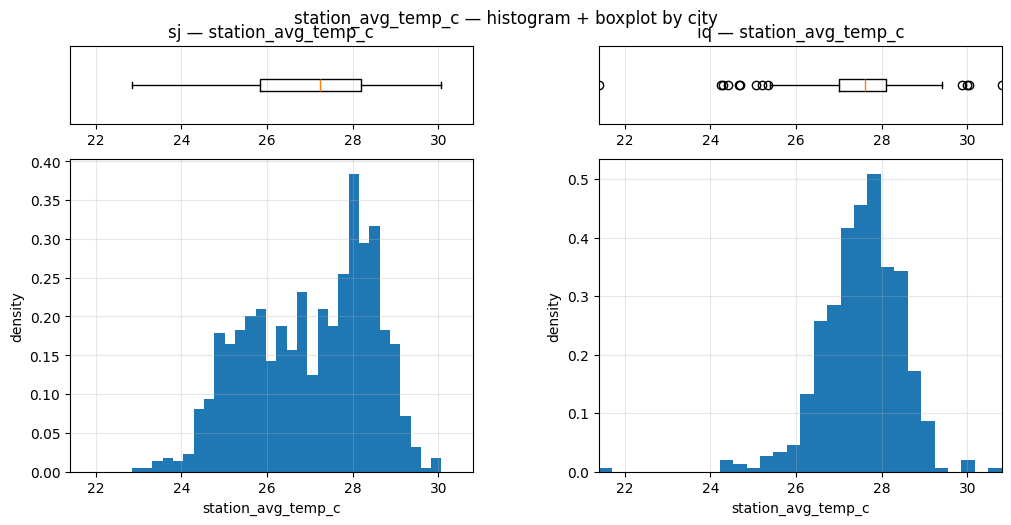

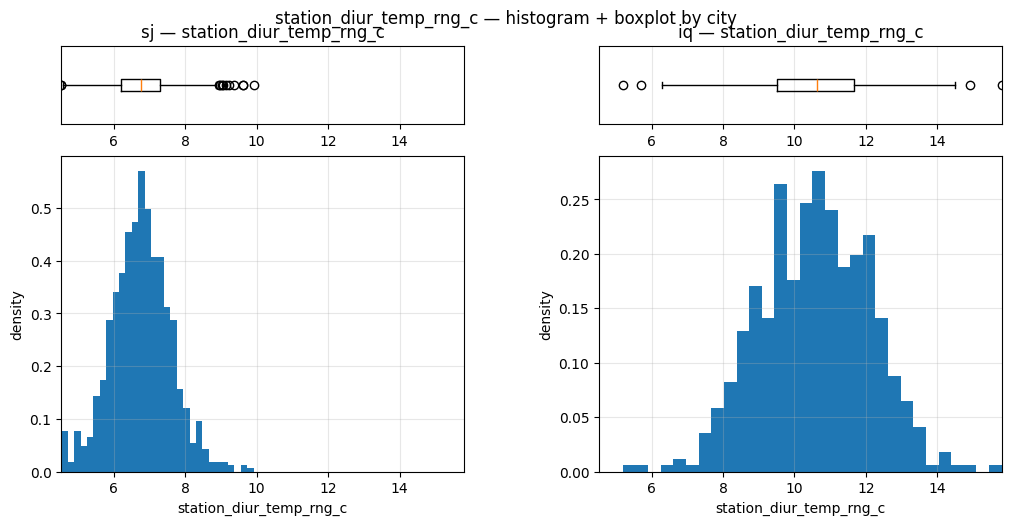

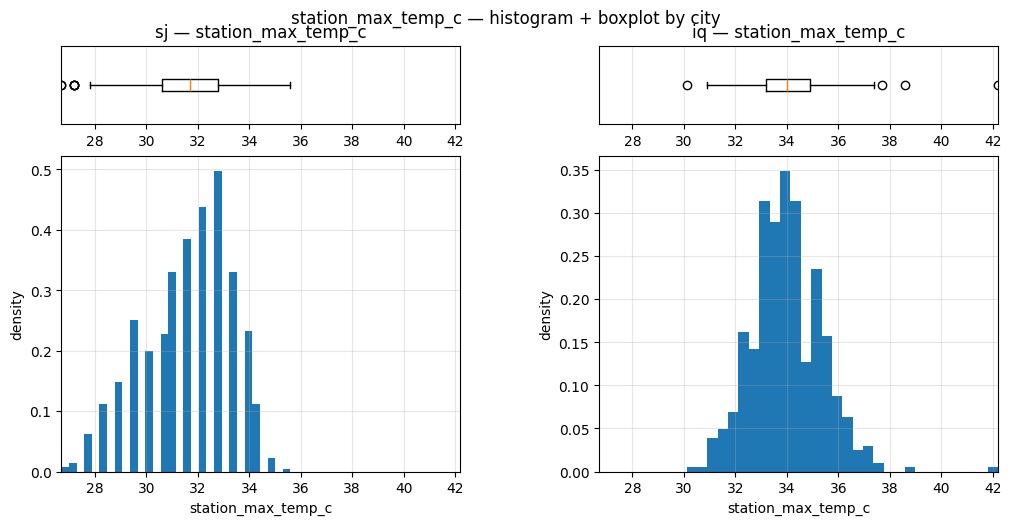

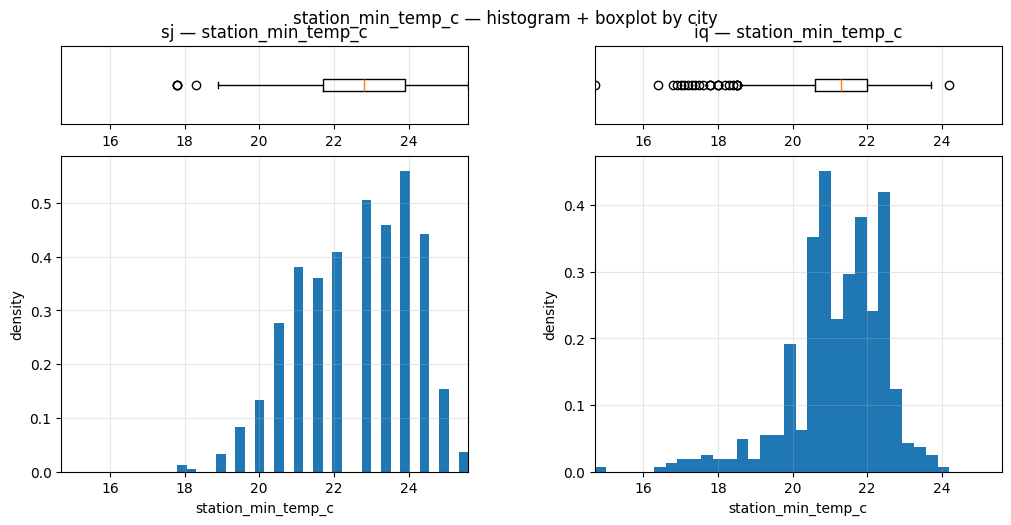

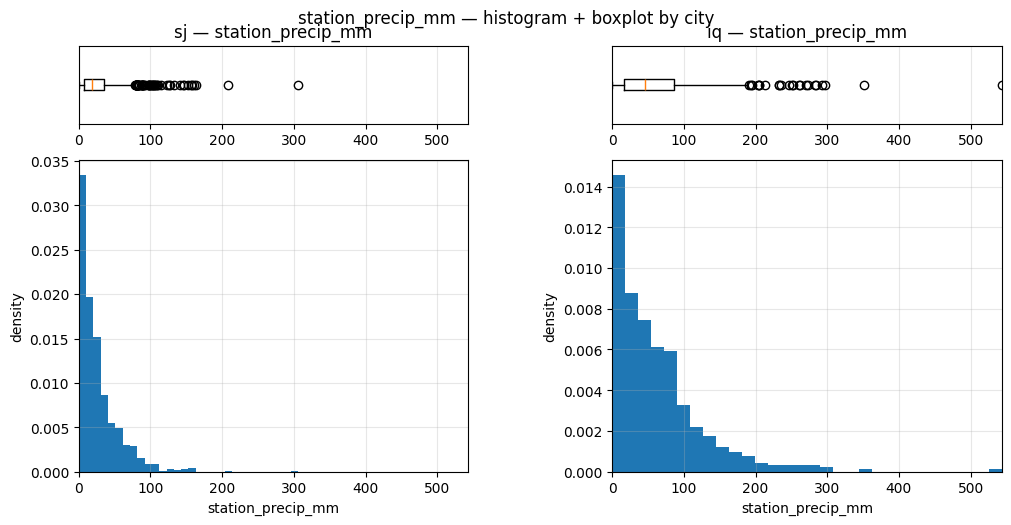

In [40]:
# Histograms + top boxplots for ALL numeric features, left=SJ, right=IQ

# Build the feature list (numeric features only, excluding keys/target)
TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)
all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

def plot_hist_box_by_city(df_feat: pd.DataFrame, col: str, cities=("sj","iq"), bins=30):
    """For a given feature col, draw SJ (left) and IQ (right): top=boxplot, bottom=histogram."""
    data_city = {c: df_feat.loc[df_feat["city"]==c, col].dropna().values for c in cities}
    # If both empty, skip
    if all(len(v)==0 for v in data_city.values()):
        print(f"[skip] {col}: no data for selected cities")
        return

    # Common x-limits across cities to align boxplots and histograms
    xs = np.concatenate([v for v in data_city.values() if len(v)>0])
    x_min, x_max = np.nanmin(xs), np.nanmax(xs)
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_min==x_max:
        # fallback if degenerate
        x_min, x_max = (x_min-1, x_max+1) if np.isfinite(x_min) else (-1, 1)

    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 4], wspace=0.15)

    for j, city in enumerate(cities):
        arr = data_city[city]
        # BOX (top row)
        ax_box = fig.add_subplot(gs[0, j])
        if len(arr):
            ax_box.boxplot(arr, vert=False, showfliers=True)
        ax_box.set_xlim(x_min, x_max)
        ax_box.set_yticks([])
        ax_box.set_xlabel("")
        ax_box.set_title(f"{city} — {col}")
        ax_box.grid(True, axis="x", alpha=0.3)

        # HIST (bottom row)
        ax_hist = fig.add_subplot(gs[1, j])
        if len(arr):
            ax_hist.hist(arr, bins=bins, density=True)
        ax_hist.set_xlim(x_min, x_max)
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel("density")
        ax_hist.grid(True, alpha=0.3)

    fig.suptitle(f"{col} — histogram + boxplot by city", y=1.02, fontsize=12)
    plt.show()

print("Total numeric features:", len(FEATURES_ALL))
for feature in FEATURES_ALL:
    plot_hist_box_by_city(feat_train, feature)


**Histograms & boxplots — interpretation:**

**City contrasts (location & spread)**
- Many variables show **systematic shifts between cities**.
  - **NDVI**: distributions center **higher in Iquitos (iq)** (≈0.20–0.35+) than **San Juan (sj)** (≈0.05–0.25), with fatter right tails in iq.
  - **Diurnal temperature range** (`station_diur_temp_rng_c`, `reanalysis_tdtr_k`): **much larger in iq**; sj is tightly clustered at lower values.
  - **Station temperatures**: **iq** tends to have **higher max** temps and **lower min** temps than **sj** → wider station-range in iq.
  - **Relative humidity**: iq’s distribution is shifted toward **higher values** with right-skew; sj is centered lower and more symmetric.
  - **Reanalysis temps** (air/avg/min/max in K): both cities are compact and near-Gaussian, but **centers differ slightly**.

**Skewness & zero-inflation**
- **Precipitation** variables (`precipitation_amt_mm`, `reanalysis_precip_amt_kg_per_m2`, `station_precip_mm`) are **heavily right-skewed** in both cities with **many zeros** and numerous high-value outliers (seen in boxplots).

**Outliers**
- Most extreme points appear in **precipitation** (many high-end outliers, especially in sj’s station and reanalysis precip).
- Occasional NDVI extremes near the lower bound (negative values) are visible, but the bulk remains within typical ranges.

**Distribution shape & redundancy hints**
- Temperature families (min/avg/max/air/dew point) are **unimodal and narrow**, suggesting **strong redundancy** within the family.
- Humidity measures are moderately spread; iq leans higher.

---

**Conclusions we can draw *now* (from these plots alone)**
- Include **city effects** in modeling (at minimum a `city` indicator); pooling without accounting for city differences will blur signals.
- Handle **precipitation** with care: consider **transformations** (e.g., `log1p`) and a **wet/dry indicator** to address zero-inflation and long tails.
- Expect **redundancy** among temperature variables; regularization or selective inclusion can help linear models (trees will cope better).
- Watch **outliers**: clipping/winsorizing **precip** (and possibly rare NDVI extremes) may stabilize linear models.
- If standardizing features for linear models, prefer **city-wise scaling**, given the clear location shifts between sj and iq.

*Note:* Correlations, seasonality, and lag structure are **not** inferred here and will be analyzed in subsequent subsections.


<a id="eda-features-corr"></a>
### <span style="color:blue">**Feature analysis — correlations (features vs. features):**</span>

We examine **linear correlations** among numeric **features only** (no target yet) to spot redundancy and families that move together.  
Notes: we **exclude time keys** (`year`, `weekofyear`) and compute pairwise correlations using non-missing rows. We show a **global** heatmap (both cities together) and **per-city** heatmaps to reveal city-specific patterns. A table of the **top correlated pairs** helps identify candidates for pruning or regularization later.


In [43]:
# Build the feature list (numeric features only, excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)

num_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ONLY = [c for c in num_cols if c not in NON_FEATURES]

print("Number of numeric features:", len(FEATURES_ONLY))


Number of numeric features: 20


In [45]:
# Utility: plot a correlation heatmap with matplotlib (no seaborn)

def plot_corr_heatmap(corr_df, title):
    cols = corr_df.columns.tolist()
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_df.values, vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(cols))); ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols, rotation=90, fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Pearson r")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def top_corr_pairs(corr_df, k=20, min_abs=None):
    """Return top |corr| pairs from an NxN matrix (upper triangle, no diagonal)."""
    cols = corr_df.columns
    vals = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr_df.iloc[i, j]
            vals.append((cols[i], cols[j], r, abs(r)))
    out = pd.DataFrame(vals, columns=["feat_1","feat_2","corr","abs_corr"]).sort_values("abs_corr", ascending=False)
    if min_abs is not None:
        out = out[out["abs_corr"] >= min_abs]
    return out.head(k)


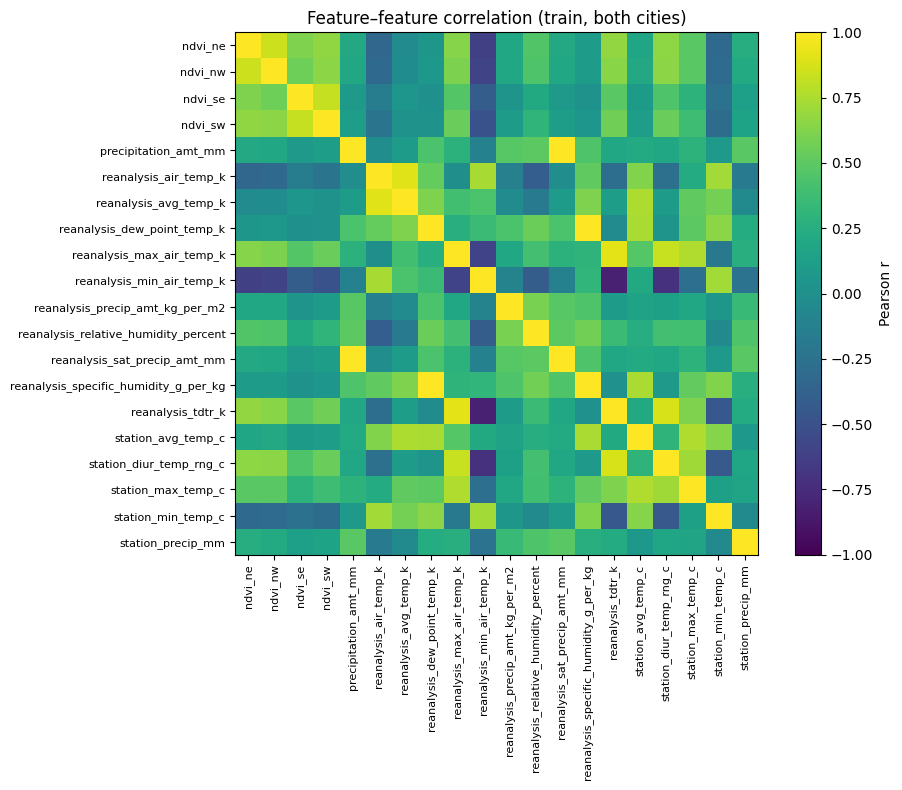

Top correlated feature pairs (global):


,feat_1,feat_2,corr,abs_corr
77,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000,1.000000
117,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.997051,0.997051
129,reanalysis_max_air_temp_k,reanalysis_tdtr_k,0.918578,0.918578
85,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.901777,0.901777
176,reanalysis_tdtr_k,station_diur_temp_rng_c,0.881176,0.881176
0,ndvi_ne,ndvi_nw,0.850902,0.850902
131,reanalysis_max_air_temp_k,station_diur_temp_rng_c,0.834263,0.834263
37,ndvi_se,ndvi_sw,0.820924,0.820924
139,reanalysis_min_air_temp_k,reanalysis_tdtr_k,-0.815511,0.815511
181,station_avg_temp_c,station_max_temp_c,0.764576,0.764576


In [46]:
# 1) Global (both cities) feature–feature correlations
corr_all = feat_train[FEATURES_ONLY].corr(method="pearson")
plot_corr_heatmap(corr_all, "Feature–feature correlation (train, both cities)")

print("Top correlated feature pairs (global):")
display(top_corr_pairs(corr_all, k=20))

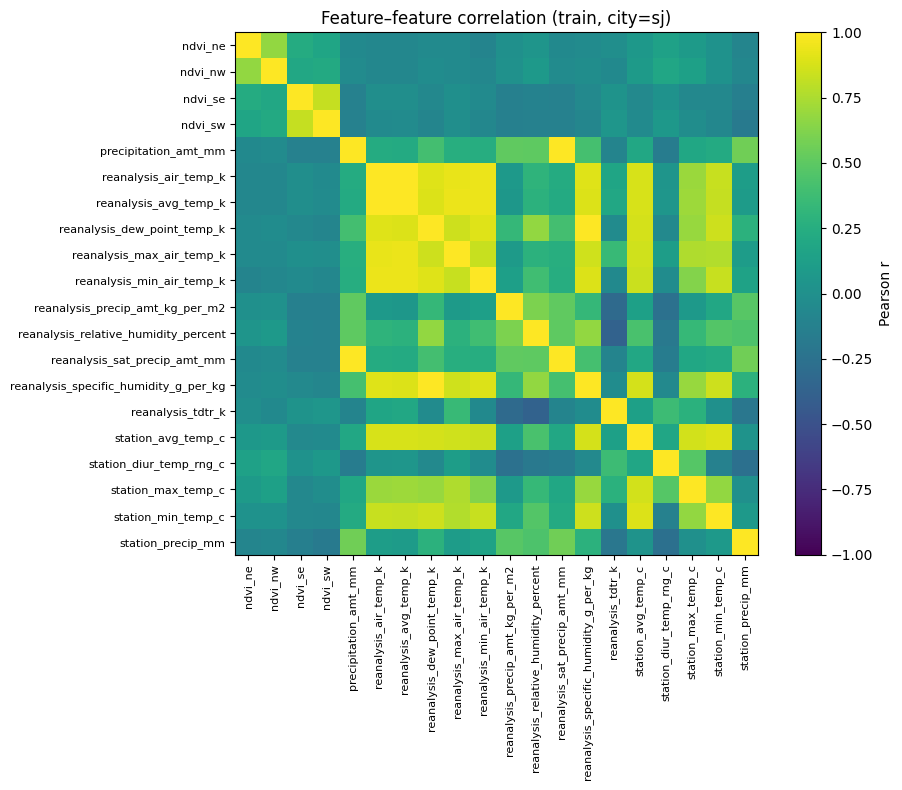

Top correlated pairs — city=sj:


,feat_1,feat_2,corr,abs_corr
77,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000,1.000000
117,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.998532,0.998532
85,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.997495,0.997495
88,reanalysis_air_temp_k,reanalysis_min_air_temp_k,0.942254,0.942254
101,reanalysis_avg_temp_k,reanalysis_min_air_temp_k,0.939120,0.939120
100,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,0.938952,0.938952
87,reanalysis_air_temp_k,reanalysis_max_air_temp_k,0.935089,0.935089
92,reanalysis_air_temp_k,reanalysis_specific_humidity_g_per_kg,0.904819,0.904819
86,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,0.903287,0.903287
113,reanalysis_dew_point_temp_k,reanalysis_min_air_temp_k,0.898814,0.898814


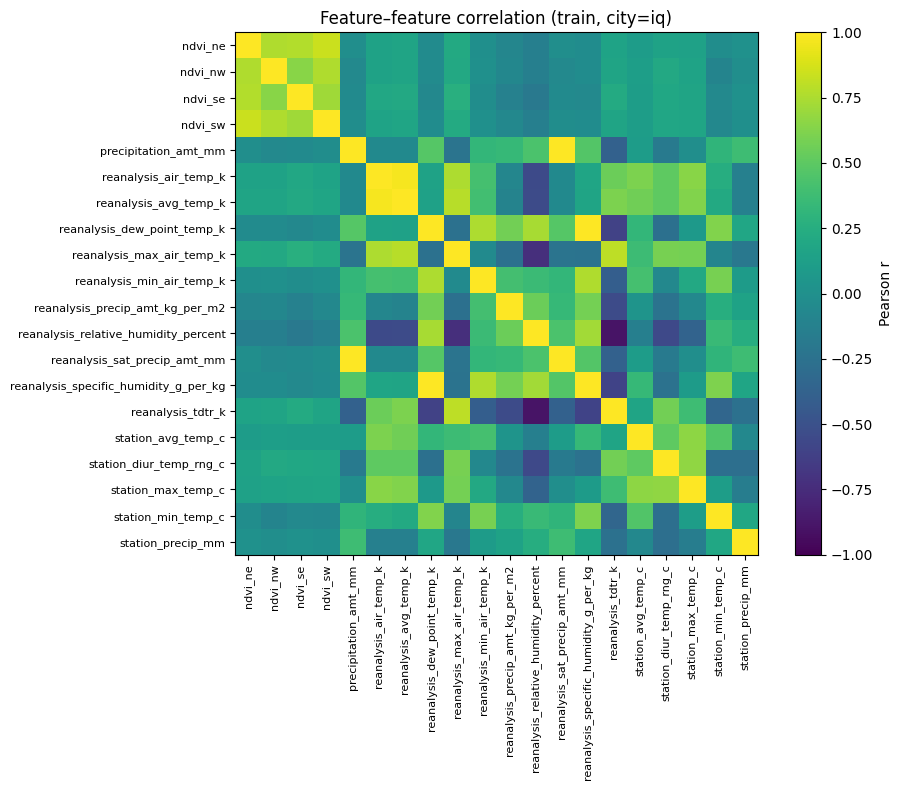

Top correlated pairs — city=iq:


,feat_1,feat_2,corr,abs_corr
77,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000,1.000000
117,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.997775,0.997775
85,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.973319,0.973319
156,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,-0.896491,0.896491
2,ndvi_ne,ndvi_sw,0.842784,0.842784
129,reanalysis_max_air_temp_k,reanalysis_tdtr_k,0.799293,0.799293
100,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,0.783955,0.783955
1,ndvi_ne,ndvi_se,0.767745,0.767745
20,ndvi_nw,ndvi_sw,0.764829,0.764829
0,ndvi_ne,ndvi_nw,0.764407,0.764407


In [47]:
# 2) Per-city correlations
for city in ["sj", "iq"]:
    subset = feat_train.loc[feat_train["city"] == city, FEATURES_ONLY]
    corr_city = subset.corr(method="pearson")
    plot_corr_heatmap(corr_city, f"Feature–feature correlation (train, city={city})")
    print(f"Top correlated pairs — city={city}:")
    display(top_corr_pairs(corr_city, k=15))


**Feature analysis — correlations: interpretation (features vs. features)**

**Strong redundancy (|r| ≥ 0.9) — clear duplicates/families**
- **Precipitation (satellite):** `precipitation_amt_mm` ↔ `reanalysis_sat_precip_amt_mm` ≈ **1.00** in **both** cities → effectively duplicates; keep **one**.
- **Temperature level (reanalysis):**
  - `reanalysis_air_temp_k` ↔ `reanalysis_avg_temp_k` ≈ **0.90–0.97**.
  - `reanalysis_min_air_temp_k`/`max_air_temp_k` each correlate strongly with the **avg/air** temp (≈ **0.89–0.94**).
- **Moisture state:** `reanalysis_dew_point_temp_k` ↔ `reanalysis_specific_humidity_g_per_kg` ≈ **0.99**.
- **NDVI quadrants:** within-quadrant pairs are high (e.g., `ndvi_ne` ↔ `ndvi_nw` ≈ **0.85**, `ndvi_se` ↔ `ndvi_sw` ≈ **0.82**).

**Moderate-to-strong structure (0.7 ≤ |r| < 0.9) — related but not identical**
- **Thermal range vs. level:** `reanalysis_tdtr_k` (diurnal range) relates to level measures:
  - Positive with `reanalysis_max_air_temp_k` (≈ **0.80** global).
  - Negative with `reanalysis_min_air_temp_k` (≈ **−0.82** global).
- **Station vs. reanalysis temps:** station averages/max/min correlate with reanalysis temps (**0.72–0.76**), i.e., same signal measured differently.

**City-specific notes**
- In **sj**, temp–temp correlations are **very high** (avg/air/min/max often **> 0.93**), reinforcing redundancy.
- In **iq**, `reanalysis_relative_humidity_percent` ↔ `reanalysis_tdtr_k` is **strongly negative** (≈ **−0.90**), stronger than in sj — local climate dynamics differ.
- The perfect precip duplicate holds in **both** cities.

**What we can safely conclude from these correlation plots**
- Several columns are **near-duplicates**; carrying all of them adds little information and increases multicollinearity.
- Reasonable **minimal representatives** (for linear baselines) could be:
  - **Precipitation:** keep **one** of {`precipitation_amt_mm`, `reanalysis_sat_precip_amt_mm`}; consider keeping **station_precip_mm** as an independent source.
  - **Temperature level:** keep **one** level metric (e.g., `reanalysis_avg_temp_k` **or** `reanalysis_air_temp_k`) **plus** a **range** metric (`reanalysis_tdtr_k` or `station_diur_temp_rng_c`).
  - **Moisture:** keep **one** of {`reanalysis_dew_point_temp_k`, `reanalysis_specific_humidity_g_per_kg`}.
  - **NDVI:** compress quadrants (e.g., mean or first PC) or keep **one per hemisphere** if needed.
- For **tree ensembles**, redundancy is less harmful, but it can **dilute feature importance**; still reasonable to prune exact duplicates (precip pair).

*Scope note:* These conclusions are based solely on **feature–feature** correlations (no target). We’ll assess **feature–target** relationships and **seasonality** in subsequent subsections.


<a id="eda-features-seasonality"></a>
### <span style="color:blue">**Feature analysis — seasonality (features only):**</span>

We examine **annual cycles** of every numeric **feature** by averaging values over `weekofyear` for each **city**.  
Below we (1) plot per-feature seasonal profiles (sj vs iq), and (2) compute a compact **seasonality summary** per feature & city (peak week, trough week, amplitude, relative amplitude).


In [48]:
# Build the feature list (numeric features only, excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)
all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

print("Total numeric features:", len(FEATURES_ALL))


Total numeric features: 20


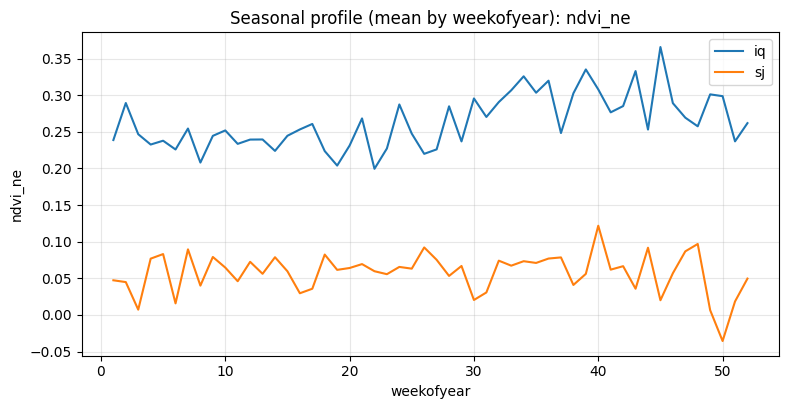

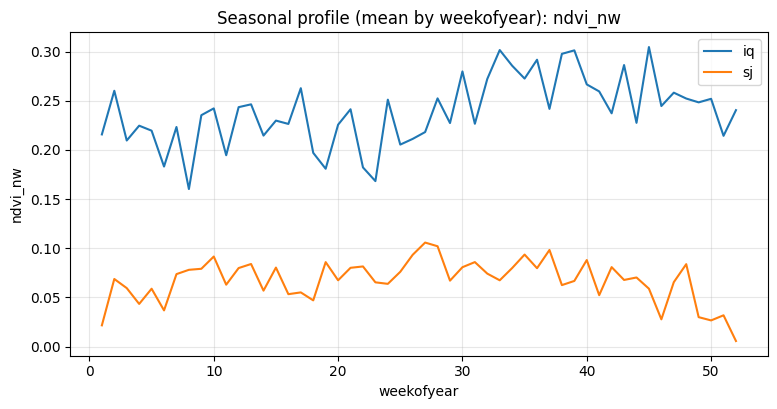

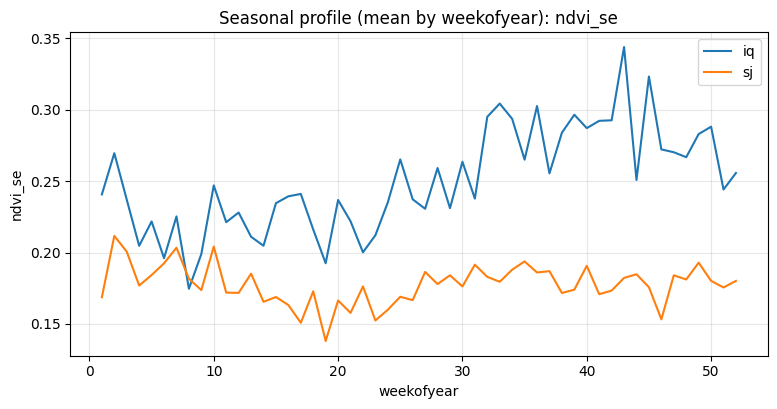

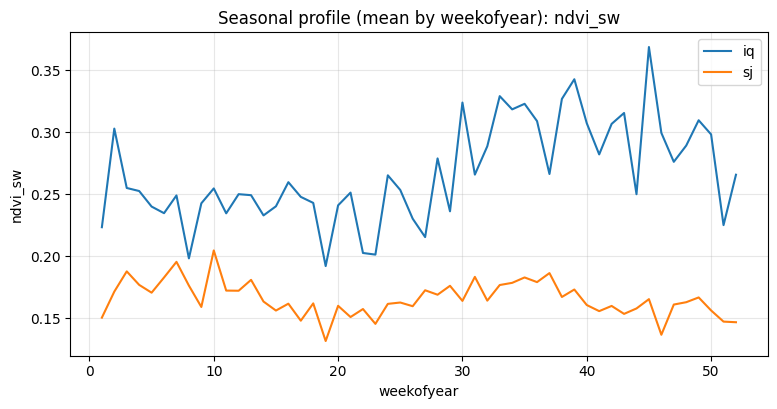

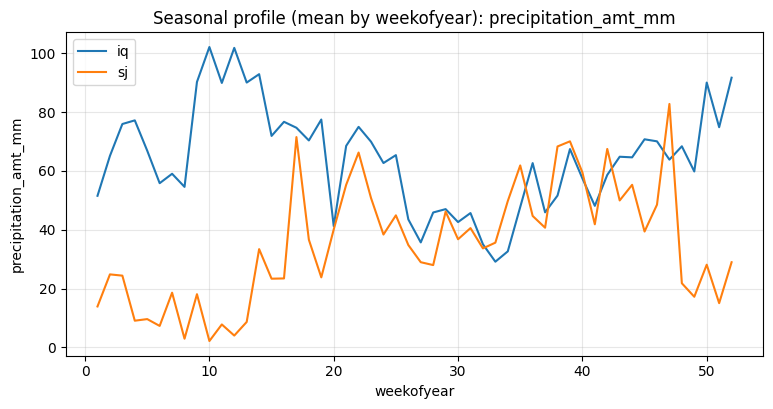

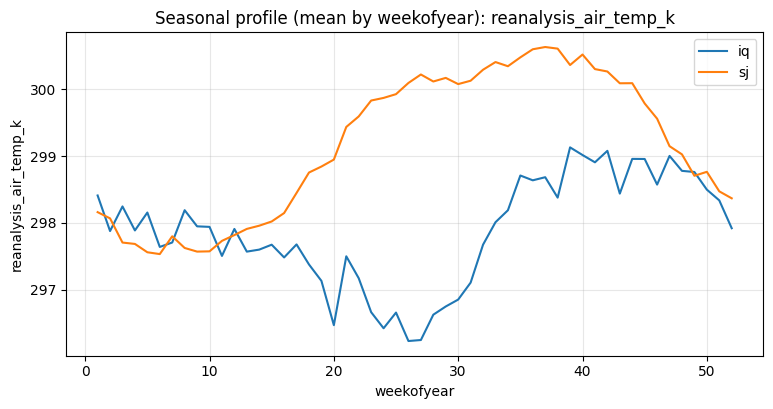

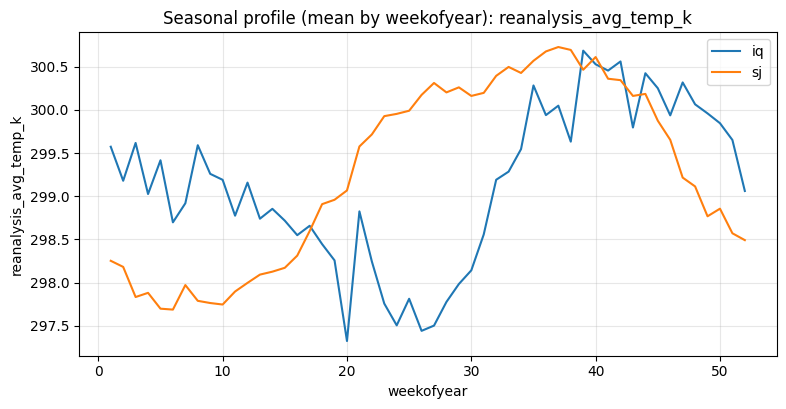

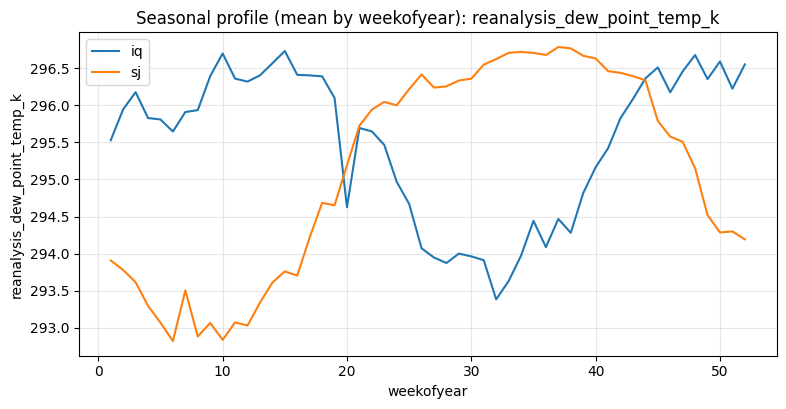

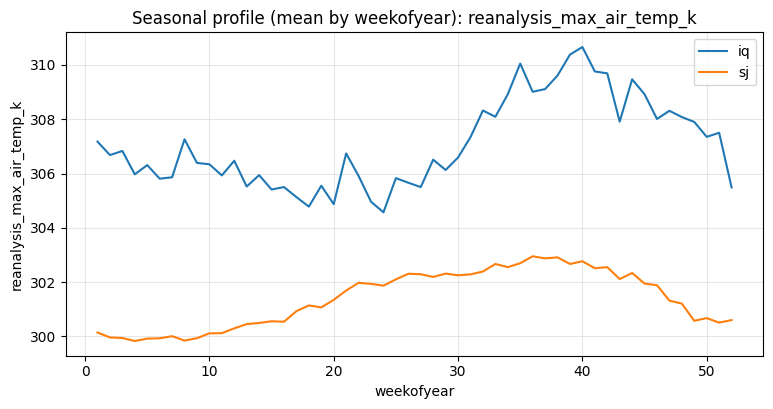

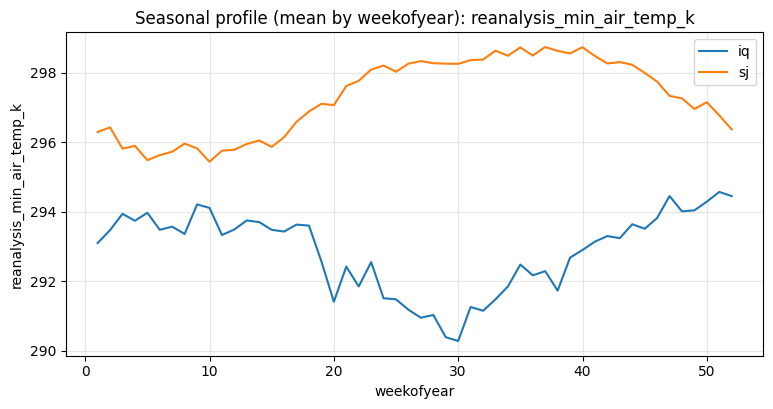

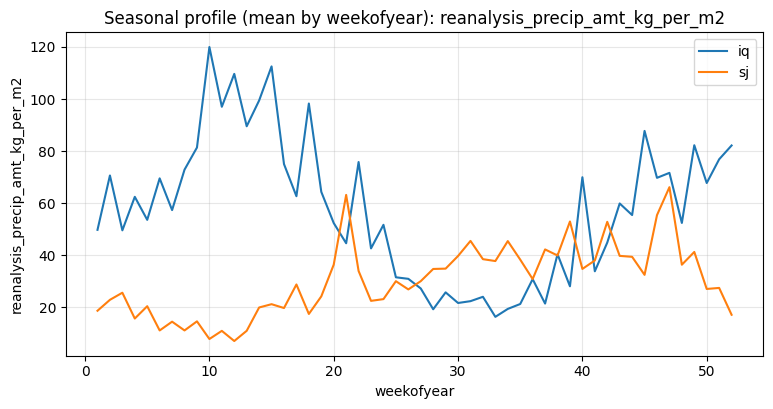

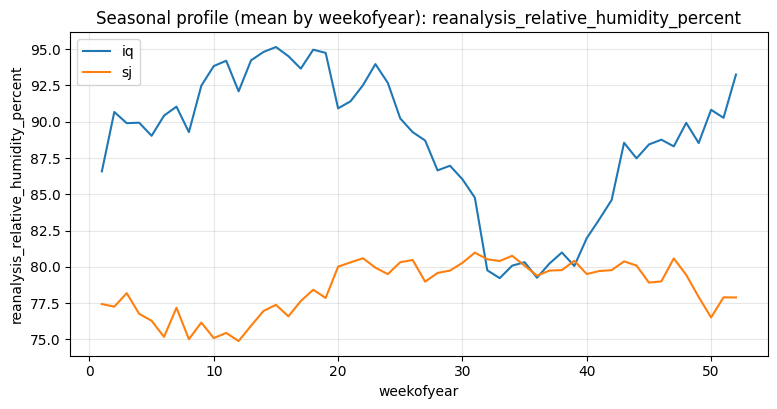

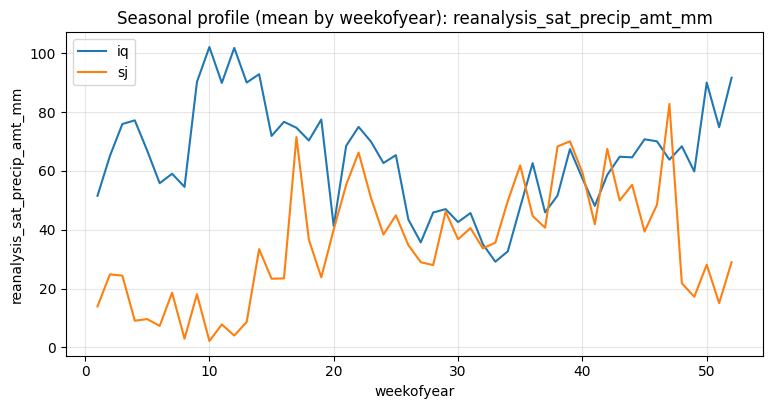

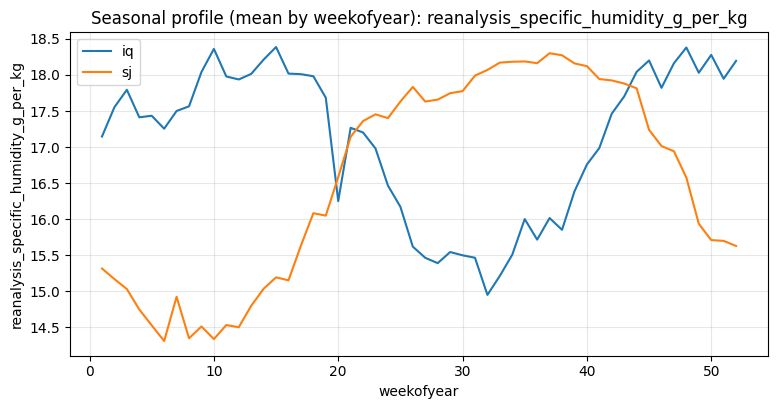

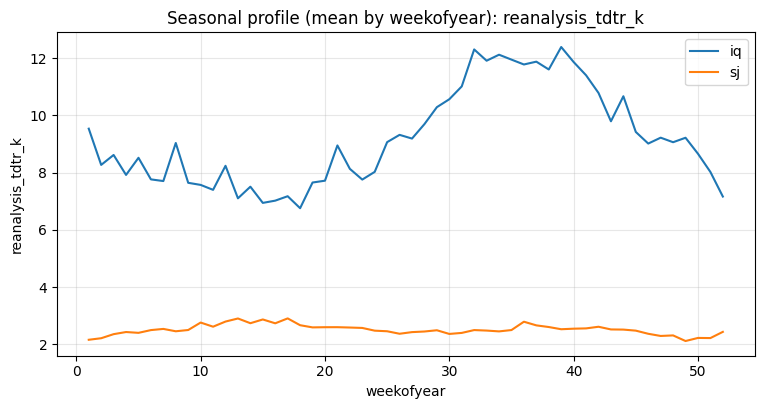

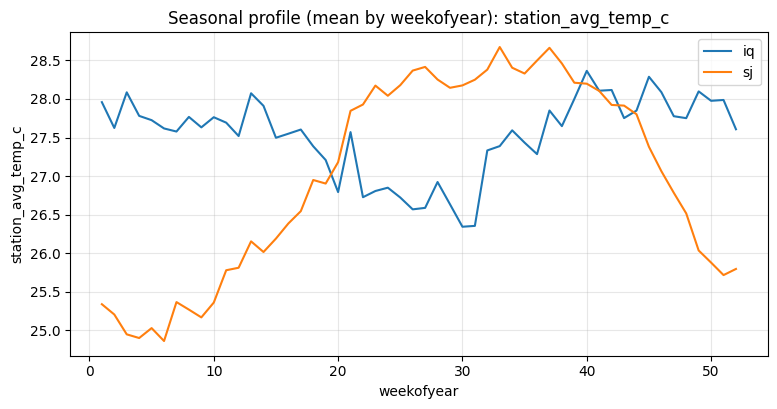

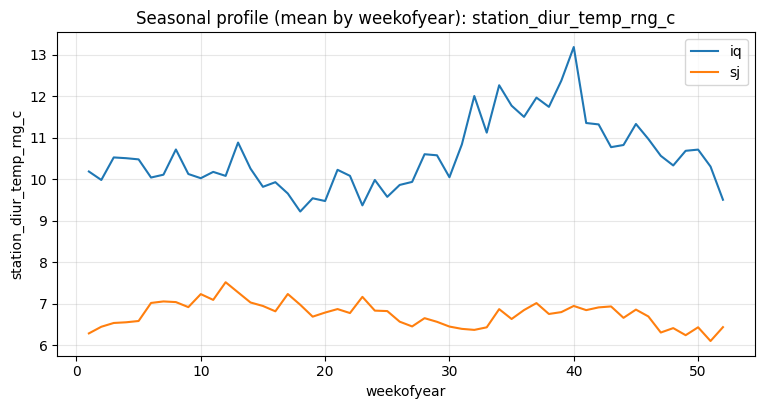

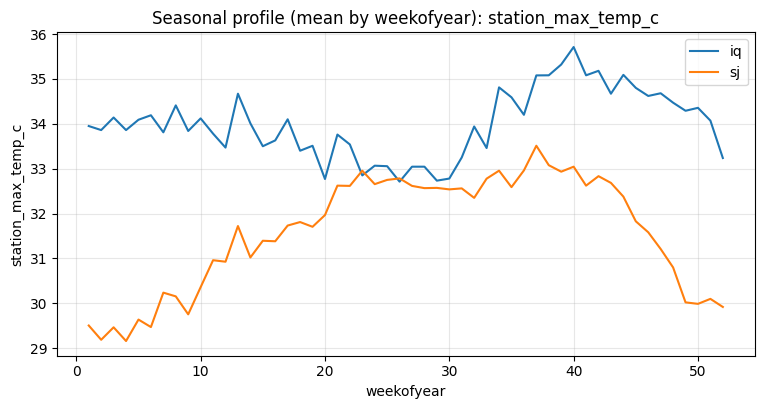

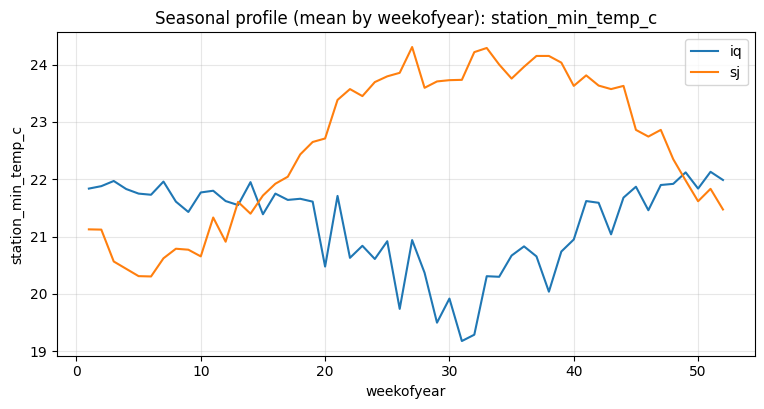

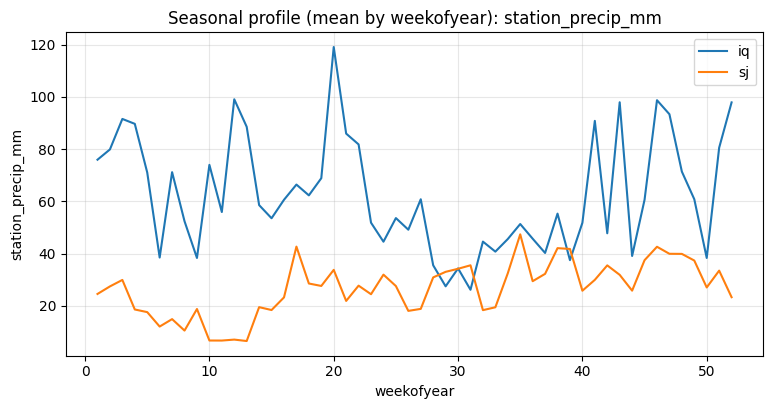

In [49]:
# 1) Seasonal profile plots for ALL features (mean by weekofyear), overlay sj vs iq
for col in FEATURES_ALL:
    prof = (
        feat_train.groupby(["city", "weekofyear"])[col]
        .mean()
        .reset_index()
        .sort_values(["city", "weekofyear"])
    )
    plt.figure(figsize=(9, 4.2))
    for city, g in prof.groupby("city"):
        plt.plot(g["weekofyear"], g[col], label=city)
    plt.title(f"Seasonal profile (mean by weekofyear): {col}")
    plt.xlabel("weekofyear"); plt.ylabel(col)
    plt.grid(alpha=0.3); plt.legend(); plt.show()


**Feature analysis — seasonality (interpretation from plots):**

**NDVI**
- **iq** sits consistently **higher** than **sj** across all quadrants.
- iq shows a **late-year rise** with peaks roughly **wk 35–45**; sj is **lower and flatter** with only a mild late-year bump.

**Precipitation**
- **iq**: pronounced **wet season** in **wk ~8–16**, a **mid-year lull** (**wk ~24–30**), then a **secondary rise** toward **wk ~40–52** (bi-modal pattern).
- **sj**: relatively **dry early year**, then **rainy season** peaks around **wk ~35–45**.
- Satellite and station/reanalysis series **agree** on these shapes.

**Temperature**
- **sj** shows a clear **summer hump** (air/avg/max/min) peaking **wk ~30–40** and cooling afterward.
- **iq** varies **less in level** but **dips mid-year** (wk ~25–35) then increases late-year; **max** temp also humps mid-year.
- **Diurnal range** (`reanalysis_tdtr_k`, `station_diur_temp_rng_c`) is **much larger in iq** and **peaks mid-year**; in sj it is **small and fairly flat**.

**Humidity**
- **iq**: **very high** (often >90% RH) with a **mid-year dip** aligned with higher diurnal range; **specific humidity & dew point** fall mid-year and recover later.
- **sj**: **moderate** RH that **rises into mid/late year**; dew point and specific humidity track the same pattern.

**Consistencies across data sources**
- Station vs. reanalysis/satellite curves show **coherent seasonal shapes**, increasing confidence in the signals.

**Takeaways from these seasonal profiles**
- Both cities exhibit **strong annual cycles**, but **phases differ** (e.g., iq’s early-year rains vs. sj’s late-year rains).
- **Amplitude** is feature- and city-dependent (e.g., **large** for iq diurnal range and RH, **small** for sj NDVI).
- These phase and amplitude differences imply we should **encode seasonality explicitly** (cyclic time) and allow **city-specific** seasonal behavior in later modeling.

- **“Encode seasonality explicitly (cyclic time)”**  
  Your plots show strong *yearly cycles*, but `weekofyear` is an integer where **week 52 and week 1 look far apart** even though they are consecutive.  
  So we map time-of-year onto a **circle** with sine/cosine:
 $$
  \theta = 2\pi \cdot \frac{\text{day-of-year}}{L}\quad (L=365\text{ or }366),\quad
  \text{season\_sin}=\sin\theta,\ \text{season\_cos}=\cos\theta
 $$
  (optionally add harmonics $k=2,3$ for semi-annual, etc.).  
  This lets any model “see” that the year **wraps around** smoothly.

- **“Allow city-specific seasonal behavior”**  
  The **timing (phase)** and **size (amplitude)** of cycles differ between **sj** and **iq** in your plots (e.g., iq’s early-year rains vs. sj’s late-year peak).  
  Don’t force one identical seasonal curve for both cities. Give the model **separate seasonal weights per city**. Three common ways:
  1. **Interactions (global model):** include `city` × (seasonal sin/cos) so each city has its **own coefficients** for the same cyclic basis.  
     *Example idea:* `season_sin1 * [city==iq]`, `season_cos1 * [city==iq]` (and similarly for sj or with one-hot dummies).
  2. **Two separate models:** train one model for **sj** and one for **iq** so each learns its own seasonality.
  3. **Flexible models with city feature:** tree ensembles can learn different patterns by splitting on `city`, but adding explicit interactions still helps linear/GLM models.

**Net effect:** cyclic features capture *the shape* of the year, and city-specific coefficients (or per-city models) capture the **different phase/amplitude** you observed.


**Seasonality metrics — what they mean:**

- **Peak week**  
  The `weekofyear` at which the **mean value** of a feature (averaged over all years for that city) is **highest**.  
  *Use*: when in the year the feature typically peaks.

- **Trough week**  
  The `weekofyear` at which the **mean value** is **lowest**.  
  *Use*: when the feature is typically at its minimum.

- **Amplitude**  
  The **size of the seasonal swing**:  
 $$
  \text{amplitude} = \text{peak\_value} - \text{trough\_value}
  $$ 
  Units are the same as the feature (e.g., °C, mm, NDVI).  
  *Use*: how large the annual cycle is in absolute terms.

- **Relative amplitude**  
  A **unitless** measure of seasonal strength that makes features comparable:  
 $$
  \text{relative amplitude} = \frac{\text{amplitude}}{\text{mean\_level}}
  $$  
  Often read as a percentage (e.g., 0.25 → 25% swing around the mean).  
  *Use*: compare seasonality strength across features/cities.

**Interpretation tips**
- Peak/trough weeks give the **timing** of highs/lows; they help reason about **lags** to the target later.
- Amplitude shows **how much** a feature moves seasonally; relative amplitude compares **across scales**.
- For features with very small means (e.g., precipitation in dry seasons), relative amplitude can be unstable; consider smoothing the weekly means (e.g., 3–5 week rolling) before computing these metrics.


In [50]:
# 2) Seasonality summary table: peak/trough week and amplitudes per feature & city
rows = []
for col in FEATURES_ALL:
    for city, g in feat_train.groupby("city"):
        prof = g.groupby("weekofyear")[col].mean()
        if prof.dropna().empty:
            continue
        peak_week = int(prof.idxmax())
        trough_week = int(prof.idxmin())
        peak_val = float(prof.loc[peak_week])
        trough_val = float(prof.loc[trough_week])
        amp = peak_val - trough_val
        mean_val = float(prof.mean())
        rel_amp = amp / mean_val if mean_val != 0 else np.nan
        rows.append({
            "feature": col,
            "city": city,
            "peak_week": peak_week,
            "trough_week": trough_week,
            "amplitude": amp,
            "relative_amplitude": rel_amp,
            "mean_level": mean_val
        })

seasonality_summary = pd.DataFrame(rows).sort_values(
    ["city", "relative_amplitude"], ascending=[True, False]
).reset_index(drop=True)

print("Seasonality summary (sorted by relative amplitude within city):")
display(seasonality_summary)


Seasonality summary (sorted by relative amplitude within city):


,feature,city,peak_week,trough_week,amplitude,relative_amplitude,mean_level
0,reanalysis_precip_amt_kg_per_m2,iq,10,33,103.555000,1.795516,57.674240
1,station_precip_mm,iq,20,31,92.900000,1.483964,62.602596
2,precipitation_amt_mm,iq,10,33,72.990000,1.135102,64.302615
3,reanalysis_sat_precip_amt_mm,iq,10,33,72.990000,1.135102,64.302615
4,ndvi_se,iq,43,8,0.169375,0.677247,0.250094
5,ndvi_sw,iq,45,19,0.176968,0.663489,0.266724
6,ndvi_ne,iq,45,22,0.166276,0.630282,0.263812
7,reanalysis_tdtr_k,iq,39,18,5.631429,0.612098,9.200206
8,ndvi_nw,iq,45,8,0.144488,0.605180,0.238752
9,station_diur_temp_rng_c,iq,40,18,3.963704,0.375014,10.569487


<a id="eda-features-seasonality-anom"></a>
### <span style="color:blue">**Feature analysis — seasonality (seasonal index & anomalies):**</span>

**Idea.** For each feature, city, and `weekofyear`, compute a **seasonal index**  
\\(S_{c,w} = \mathrm{mean}\big[x \mid \text{city}=c,\ \text{weekofyear}=w\big]\\).  
Then define **anomalies** as deviations from this seasonal baseline:
- absolute: \\(a = x - S_{c,w}\\)
- percent: \\(a_{\%} = \frac{x - S_{c,w}}{S_{c,w}}\\) (when $S_{c,w}\neq 0$\)

**Why.** This separates “typical seasonal level” from **departures** (e.g., unusually wet weeks). Later, you can feed anomalies (and the baseline itself) as covariates.

> ⚠️ EDA here uses the full dataset just to **inspect** behavior.  
> For modeling, re-compute the seasonal index **inside each time-aware CV fold using past data only** to avoid leakage.


In [55]:
# Seasonal index & anomalies for ALL numeric features (excluding keys/target)

TIME_KEYS = ["year", "weekofyear"]
NON_FEATURES = set(["city", "week_start_date", "total_cases"] + TIME_KEYS)

all_numeric_cols = feat_train.select_dtypes(include=[np.number]).columns.tolist()
FEATURES_ALL = [c for c in all_numeric_cols if c not in NON_FEATURES]

# 1) Seasonal index per (city, weekofyear)
seasonal_idx = (
    feat_train.groupby(["city","weekofyear"])[FEATURES_ALL]
    .mean()
    .reset_index()
)

# 2) Merge back to get seasonal means alongside raw features
feat_train_si = feat_train.merge(
    seasonal_idx, on=["city","weekofyear"], suffixes=("", "_seasonal_mean")
)

# 3) Create anomalies (absolute and percent) with a safe denominator
EPS = 1e-9
for col in FEATURES_ALL:
    base = f"{col}_seasonal_mean"
    feat_train_si[f"{col}_anom"] = feat_train_si[col] - feat_train_si[base]
    denom = feat_train_si[base].where(feat_train_si[base].abs() > EPS, np.nan)
    feat_train_si[f"{col}_anom_pct"] = (feat_train_si[col] - feat_train_si[base]) / denom

print("Created seasonal means and anomalies for", len(FEATURES_ALL), "features.")


Created seasonal means and anomalies for 20 features.


In [56]:
# Quick summary table: how variable are anomalies around zero? (per feature & city)
def mad(x):
    m = np.nanmedian(x)
    return np.nanmedian(np.abs(x - m))

rows = []
for col in FEATURES_ALL:
    for city, g in feat_train_si.groupby("city"):
        a = g[f"{col}_anom"]
        ap = g[f"{col}_anom_pct"]
        rows.append({
            "feature": col,
            "city": city,
            "anom_std": float(np.nanstd(a)),
            "anom_mad": float(mad(a)),
            "anom_pct_std": float(np.nanstd(ap)),
            "seasonal_mean_mean": float(np.nanmean(g[f"{col}_seasonal_mean"])),
        })
seasonal_anom_summary = pd.DataFrame(rows).sort_values(
    ["city","anom_pct_std"], ascending=[True, False]
).reset_index(drop=True)

print("Seasonal anomaly summary (largest % variability first within city):")
display(seasonal_anom_summary.head(20))


Seasonal anomaly summary (largest % variability first within city):


,feature,city,anom_std,anom_mad,anom_pct_std,seasonal_mean_mean
0,station_precip_mm,iq,59.269540,29.743889,0.887454,62.466506
1,reanalysis_precip_amt_kg_per_m2,iq,42.316417,18.516000,0.696988,57.579667
2,precipitation_amt_mm,iq,30.485703,19.519875,0.509155,64.196762
3,reanalysis_sat_precip_amt_mm,iq,30.485703,19.519875,0.509155,64.196762
4,ndvi_nw,iq,0.068498,0.049371,0.293788,0.238746
5,ndvi_sw,iq,0.076373,0.051970,0.293365,0.266727
6,ndvi_ne,iq,0.072427,0.052164,0.279207,0.263819
7,ndvi_se,iq,0.068260,0.048227,0.277458,0.250072
8,reanalysis_tdtr_k,iq,1.782221,1.236429,0.200737,9.208060
9,station_diur_temp_rng_c,iq,1.287408,0.896667,0.124300,10.573582


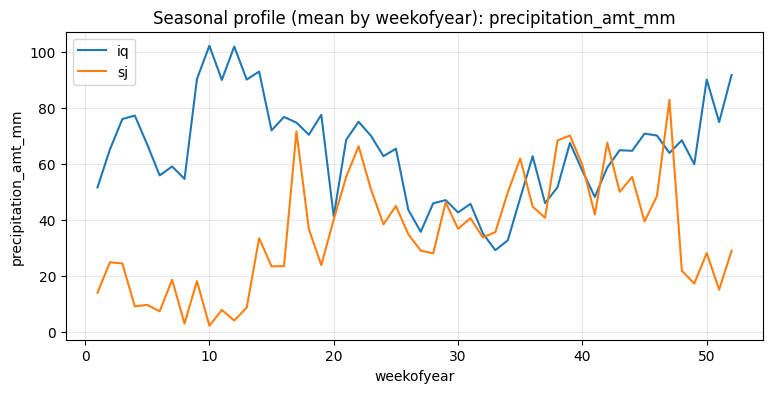

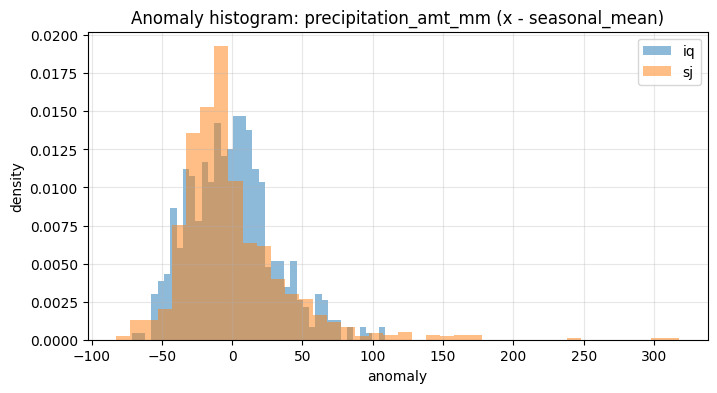

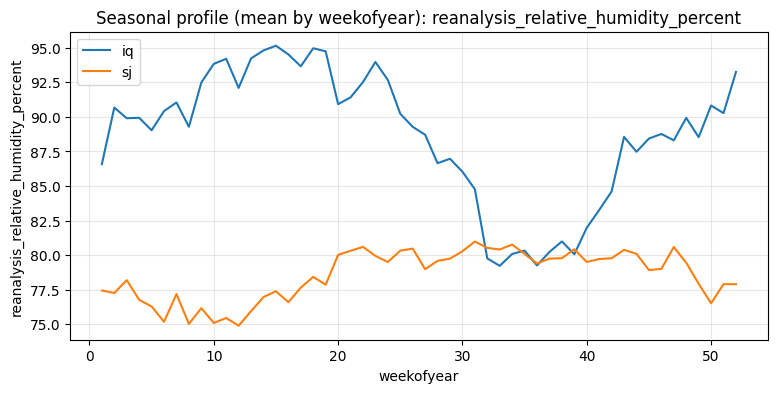

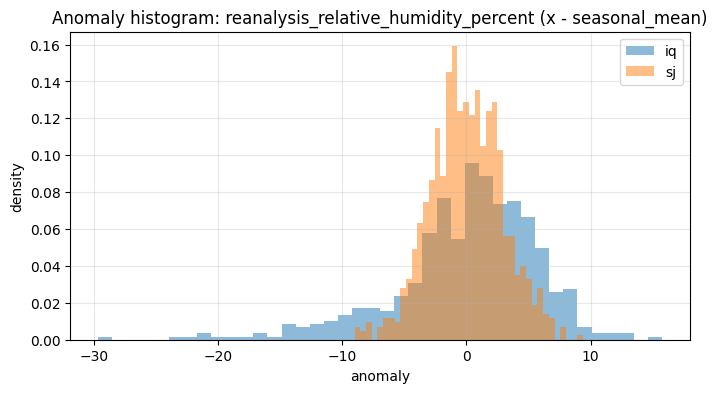

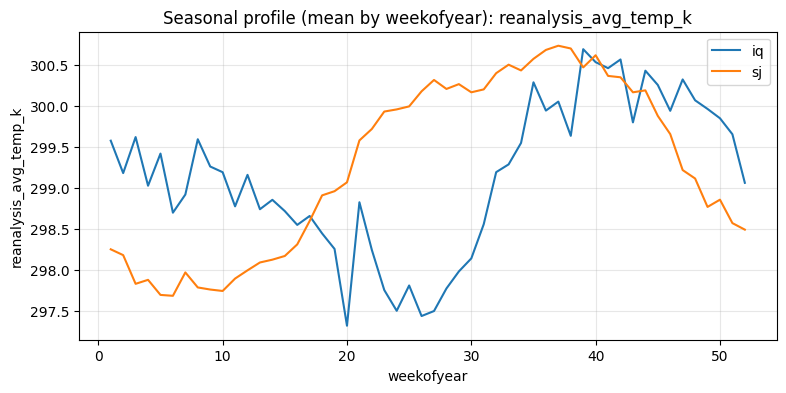

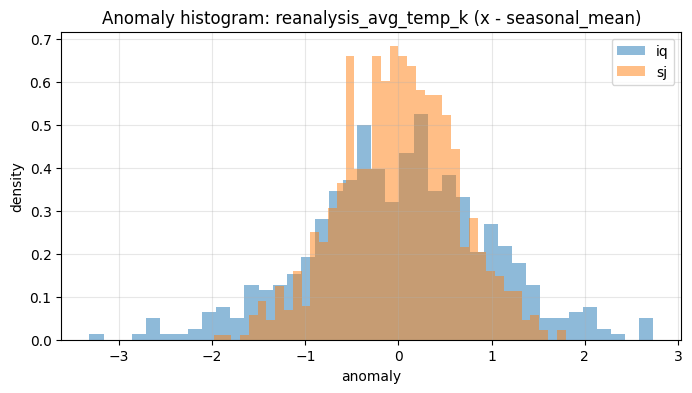

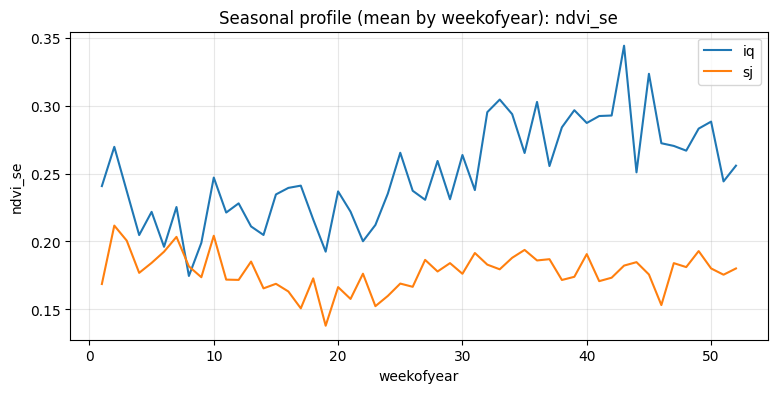

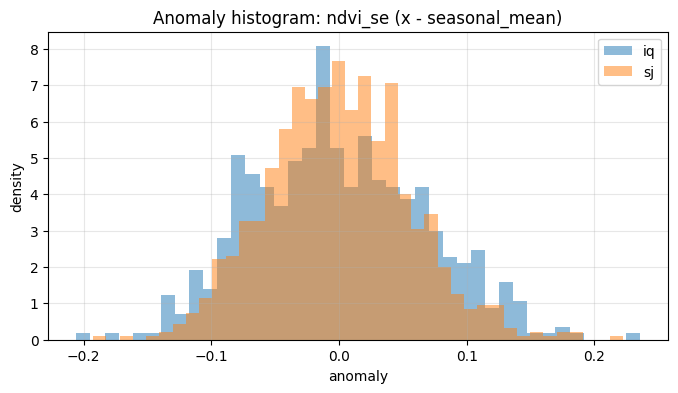

In [58]:
# Diagnostic plots for a few key features: seasonal curve + anomaly hist per city
import matplotlib.pyplot as plt

inspect_cols = [
    "precipitation_amt_mm",
    "reanalysis_relative_humidity_percent",
    "reanalysis_avg_temp_k",
    "ndvi_se",
]

for col in inspect_cols:
    # Seasonal profile (mean by weekofyear)
    prof = (
        feat_train.groupby(["city","weekofyear"])[col]
        .mean().reset_index().sort_values(["city","weekofyear"])
    )
    plt.figure(figsize=(9,4))
    for city, g in prof.groupby("city"):
        plt.plot(g["weekofyear"], g[col], label=city)
    plt.title(f"Seasonal profile (mean by weekofyear): {col}")
    plt.xlabel("weekofyear"); plt.ylabel(col); plt.grid(alpha=0.3); plt.legend(); plt.show()

    # Anomaly histogram per city
    plt.figure(figsize=(8,4))
    for city, g in feat_train_si.groupby("city"):
        data = g[f"{col}_anom"].dropna()
        plt.hist(data, bins=40, density=True, alpha=0.5, label=city)
    plt.title(f"Anomaly histogram: {col} (x - seasonal_mean)")
    plt.xlabel("anomaly"); plt.ylabel("density"); plt.grid(alpha=0.3); plt.legend(); plt.show()


**How to read this**
- If anomaly histograms are **centered near 0** and fairly **narrow**, the seasonal index captures most of the yearly structure.
- Features with **wide anomaly spread** (large `anom_pct_std`) have **volatile departures** from their typical season—often informative for dengue risk (e.g., unusually wet or dry periods).
- In Feature Engineering, you can keep **both** the seasonal baseline (the `*_seasonal_mean`) and the **anomaly** variables; remember to recompute seasonals **within each CV fold** using only past data.


**Seasonal index & anomalies — interpretation (features only):**

**Precipitation (`precipitation_amt_mm`)**
- **Seasonal profile:** iq has an **early wet season** (≈wk 8–16), a lull mid-year, then another rise; sj is **drier early** and gets **wetter late** (≈wk 35–45).
- **Anomaly histogram (x − seasonal_mean):** centered near **0** but **strongly right-skewed** with **very large positive spikes** (occasionally > +200 mm), and a broad negative side down to ~−50 mm.  
  **Implications:** positive **rainfall shocks** are rare but large—good candidates for **lagged effects**; use **log1p** and/or **winsorize** for stability; add **wet/dry flags** and **anomaly roll-ups** (e.g., 4/8/12-week sums of positive anomalies).

**Relative humidity (`reanalysis_relative_humidity_percent`)**
- **Seasonal profile:** iq stays **very humid** with a mid-year dip; sj is **moderate** and rises toward late year.
- **Anomaly histogram:** **narrow, near-Gaussian** around 0 (most within ~±10pp).  
  **Implications:** RH anomalies are **small but systematic**; keep **absolute anomalies** (pp) and consider **joint features** with temperature/diurnal range (e.g., heat-moisture interaction).

**Temperature level (`reanalysis_avg_temp_k`)**
- **Seasonal profile:** clear, smooth **annual cycle**, out of phase between cities (sj peaks later; iq dips mid-year).
- **Anomaly histogram:** **tight, symmetric** around 0 (≈±1 K for most weeks).  
  **Implications:** most temperature variation is **explained by seasonality**; anomalies are modest—use **cyclic time features** for the baseline and keep **temp anomalies** to capture heatwaves/cold snaps (with lags).

**Vegetation (`ndvi_se`)**
- **Seasonal profile:** iq’s baseline **higher** than sj, with a **gradual late-year rise**.
- **Anomaly histogram:** centered near 0, **moderate spread**, roughly symmetric.  
  **Implications:** NDVI anomalies reflect **greenness departures** (e.g., unusual dryness/wetness periods); consider **lagged anomalies** and **rolling means** (plant growth/insect habitat responds slowly).

---

**What these plots tell us about feature engineering (based on features only)**
- The **seasonal index works**: anomaly distributions are centered near **0**, meaning the baseline captures typical annual levels.
- Keep **both** the **seasonal means** (`*_seasonal_mean`) and the **anomalies** (`*_anom`, optionally `%`) as covariates; compute them **per city** and **leakage-safe** inside each time split.
- For **precipitation**, expect **zero-inflation and heavy tails** → add **log1p**, **wet/dry indicators**, and **lagged/rolling sums of positive anomalies**.
- For **temperature & humidity**, the **baseline (cyclic)** carries most signal; anomalies are **subtle** but may still matter with **appropriate lags** or **interactions** (e.g., high humidity + high temp).
- For **NDVI**, use **lagged/rolling anomalies** to capture slower ecological responses.
